In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [5]:
traces = traces_dict[TRACES]
traces.shape

(2452, 27, 27)

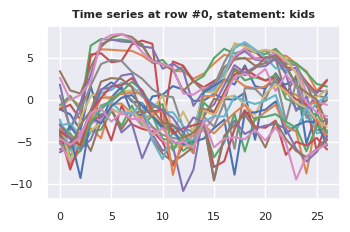

In [6]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


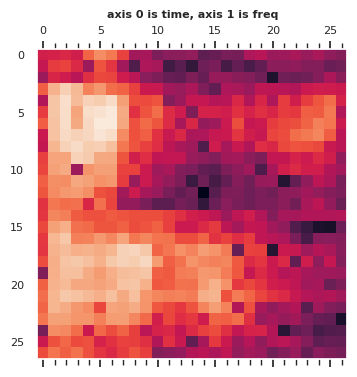

In [7]:
plt.matshow(traces[index]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

# CNN for statement and syllables 0&2

In [8]:
from sklearn.model_selection import train_test_split

# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [9]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv",
                     padding="causal"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',padding="causal", name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

2023-06-27 16:18:09.760526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 16:18:10.037599: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 16:18:10.039655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 16:18:11.836743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# Test to check the accuracy of a "belly" network
test_model = build_model((27,27), 2, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 27, 8)             1088      
                                                                 
 batch_normalization (BatchN  (None, 27, 8)            32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 27, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 27, 8)             328       
                                                                 
 batch_normalization_1 (Batc  (None, 27, 8)            32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 27, 8)             0

In [11]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-27 16:18:21,003] A new study created in memory with name: no-name-4d241949-0507-4795-beed-a94b3cf19dcd


Running little bitch having n_conv=1, dropout=0.08626704582163854, hidden_nodes=9
Running little bitch having n_conv=3, dropout=0.11308661581536168, hidden_nodes=88
Running little bitch having n_conv=3, dropout=0.0632037947163554, hidden_nodes=40
Running little bitch having n_conv=0, dropout=0.11501335062840619, hidden_nodes=212
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:18:38,177] Trial 3 finished with value: 0.979328165374677 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 212, 'dropout': 0.11501335062840619, 'filters': 10, 'kernel_size': 13, 'batch_size': 45, 'epochs': 17}. Best is trial 3 with value: 0.979328165374677.


Running little bitch having n_conv=1, dropout=0.01891874674532299, hidden_nodes=212
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:18:41,329] Trial 0 finished with value: 0.9819121447028424 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 9, 'dropout': 0.08626704582163854, 'filters': 5, 'kernel_size': 13, 'batch_size': 16, 'epochs': 7}. Best is trial 0 with value: 0.9819121447028424.


Running little bitch having n_conv=2, dropout=0.10294562003836578, hidden_nodes=252
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:18:56,455] Trial 4 finished with value: 0.8604651162790697 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 212, 'dropout': 0.01891874674532299, 'filters': 7, 'kernel_size': 2, 'batch_size': 25, 'epochs': 12}. Best is trial 0 with value: 0.9819121447028424.


Running little bitch having n_conv=2, dropout=0.19326900685507903, hidden_nodes=44
13/13 [==============================] - 1s 13ms/step


[I 2023-06-27 16:18:58,971] Trial 5 finished with value: 0.9534883720930233 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 252, 'dropout': 0.10294562003836578, 'filters': 8, 'kernel_size': 10, 'batch_size': 44, 'epochs': 6}. Best is trial 0 with value: 0.9819121447028424.


Running little bitch having n_conv=0, dropout=0.057027023517229304, hidden_nodes=86
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:19:33,812] Trial 2 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 40, 'dropout': 0.0632037947163554, 'filters': 16, 'kernel_size': 12, 'batch_size': 61, 'epochs': 66}. Best is trial 2 with value: 0.9922480620155039.


Running little bitch having n_conv=3, dropout=0.06561992608965321, hidden_nodes=74
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:19:41,580] Trial 1 finished with value: 0.9715762273901809 and parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 88, 'dropout': 0.11308661581536168, 'filters': 4, 'kernel_size': 15, 'batch_size': 39, 'epochs': 83}. Best is trial 2 with value: 0.9922480620155039.


Running little bitch having n_conv=1, dropout=0.05276021856029383, hidden_nodes=32
13/13 [==============================] - 0s 8ms/step


[I 2023-06-27 16:19:48,165] Trial 7 finished with value: 0.979328165374677 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 86, 'dropout': 0.057027023517229304, 'filters': 8, 'kernel_size': 8, 'batch_size': 34, 'epochs': 61}. Best is trial 2 with value: 0.9922480620155039.


Running little bitch having n_conv=2, dropout=0.0011056931090879464, hidden_nodes=30
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:20:00,275] Trial 6 finished with value: 0.9819121447028424 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 44, 'dropout': 0.19326900685507903, 'filters': 4, 'kernel_size': 15, 'batch_size': 28, 'epochs': 70}. Best is trial 2 with value: 0.9922480620155039.


Running little bitch having n_conv=3, dropout=0.19459934810361024, hidden_nodes=169
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:20:07,951] Trial 9 finished with value: 0.9948320413436692 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 32, 'dropout': 0.05276021856029383, 'filters': 12, 'kernel_size': 7, 'batch_size': 59, 'epochs': 36}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.0686132805843661, hidden_nodes=220
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:20:38,990] Trial 10 finished with value: 0.9431524547803618 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 30, 'dropout': 0.0011056931090879464, 'filters': 10, 'kernel_size': 3, 'batch_size': 25, 'epochs': 41}. Best is trial 9 with value: 0.9948320413436692.


Running little bitch having n_conv=1, dropout=0.02587677111356173, hidden_nodes=142
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:21:03,992] Trial 12 finished with value: 0.9974160206718347 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 220, 'dropout': 0.0686132805843661, 'filters': 13, 'kernel_size': 12, 'batch_size': 31, 'epochs': 84}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.0376139206008627, hidden_nodes=148
13/13 [==============================] - 1s 13ms/step


[I 2023-06-27 16:21:06,492] Trial 13 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 142, 'dropout': 0.02587677111356173, 'filters': 14, 'kernel_size': 6, 'batch_size': 63, 'epochs': 35}. Best is trial 12 with value: 0.9974160206718347.
[I 2023-06-27 16:21:06,522] Trial 8 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 74, 'dropout': 0.06561992608965321, 'filters': 14, 'kernel_size': 13, 'batch_size': 56, 'epochs': 89}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.0549140996443835, hidden_nodes=154
Running little bitch having n_conv=1, dropout=0.041120545078847576, hidden_nodes=147
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:21:18,368] Trial 11 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 169, 'dropout': 0.19459934810361024, 'filters': 13, 'kernel_size': 14, 'batch_size': 28, 'epochs': 57}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.03908476215043882, hidden_nodes=130
13/13 [==============================] - 0s 6ms/step


[I 2023-06-27 16:21:33,588] Trial 14 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 148, 'dropout': 0.0376139206008627, 'filters': 13, 'kernel_size': 6, 'batch_size': 61, 'epochs': 36}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=0, dropout=0.08165724544109815, hidden_nodes=187
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:21:34,611] Trial 17 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 130, 'dropout': 0.03908476215043882, 'filters': 12, 'kernel_size': 8, 'batch_size': 52, 'epochs': 28}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=0, dropout=0.08079271275203673, hidden_nodes=253
 8/13 [=================>............] - ETA: 0s

[I 2023-06-27 16:21:37,533] Trial 16 finished with value: 0.9819121447028424 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 147, 'dropout': 0.041120545078847576, 'filters': 12, 'kernel_size': 7, 'batch_size': 49, 'epochs': 28}. Best is trial 12 with value: 0.9974160206718347.


13/13 [==============================] - 1s 13ms/step
Running little bitch having n_conv=0, dropout=0.0822037813565594, hidden_nodes=198


[I 2023-06-27 16:21:37,752] Trial 15 finished with value: 0.9715762273901809 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 154, 'dropout': 0.0549140996443835, 'filters': 13, 'kernel_size': 6, 'batch_size': 52, 'epochs': 50}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=0, dropout=0.07940404610804411, hidden_nodes=109
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:21:44,969] Trial 18 finished with value: 0.9870801033591732 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 187, 'dropout': 0.08165724544109815, 'filters': 11, 'kernel_size': 9, 'batch_size': 52, 'epochs': 23}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.13098607000735926, hidden_nodes=107
13/13 [==============================] - 0s 10ms/step


[I 2023-06-27 16:21:55,888] Trial 19 finished with value: 0.979328165374677 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 253, 'dropout': 0.08079271275203673, 'filters': 16, 'kernel_size': 10, 'batch_size': 50, 'epochs': 52}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.12737207378079476, hidden_nodes=116
13/13 [==============================] - 0s 7ms/step


[I 2023-06-27 16:22:18,404] Trial 21 finished with value: 0.9896640826873385 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 109, 'dropout': 0.07940404610804411, 'filters': 16, 'kernel_size': 10, 'batch_size': 36, 'epochs': 74}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.1356282706026346, hidden_nodes=182
13/13 [==============================] - 0s 8ms/step


[I 2023-06-27 16:22:28,617] Trial 20 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 198, 'dropout': 0.0822037813565594, 'filters': 15, 'kernel_size': 10, 'batch_size': 38, 'epochs': 48}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.19019724167506927, hidden_nodes=179
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:23:00,015] Trial 22 finished with value: 0.9870801033591732 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 107, 'dropout': 0.13098607000735926, 'filters': 16, 'kernel_size': 11, 'batch_size': 36, 'epochs': 78}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.18658743899573127, hidden_nodes=177
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:23:02,493] Trial 23 finished with value: 0.9741602067183462 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 116, 'dropout': 0.12737207378079476, 'filters': 15, 'kernel_size': 4, 'batch_size': 36, 'epochs': 76}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.19114092402639107, hidden_nodes=172
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:23:14,164] Trial 24 finished with value: 0.9689922480620154 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 182, 'dropout': 0.1356282706026346, 'filters': 14, 'kernel_size': 4, 'batch_size': 31, 'epochs': 57}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.1957737276492335, hidden_nodes=233
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:24:02,809] Trial 25 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 179, 'dropout': 0.19019724167506927, 'filters': 11, 'kernel_size': 16, 'batch_size': 33, 'epochs': 58}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.17575740281665506, hidden_nodes=222
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:24:38,975] Trial 26 finished with value: 0.9896640826873385 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 177, 'dropout': 0.18658743899573127, 'filters': 11, 'kernel_size': 15, 'batch_size': 32, 'epochs': 57}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.17301591039753306, hidden_nodes=230
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:24:43,255] Trial 27 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 172, 'dropout': 0.19114092402639107, 'filters': 11, 'kernel_size': 16, 'batch_size': 31, 'epochs': 59}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.16705613124033308, hidden_nodes=231
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:24:53,835] Trial 29 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 222, 'dropout': 0.17575740281665506, 'filters': 12, 'kernel_size': 14, 'batch_size': 19, 'epochs': 43}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.1582418875488725, hidden_nodes=234
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:25:26,595] Trial 31 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 231, 'dropout': 0.16705613124033308, 'filters': 13, 'kernel_size': 12, 'batch_size': 20, 'epochs': 41}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.09323610434036372, hidden_nodes=16
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:25:36,013] Trial 30 finished with value: 0.9819121447028424 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 230, 'dropout': 0.17301591039753306, 'filters': 2, 'kernel_size': 12, 'batch_size': 20, 'epochs': 39}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.06330546164161328, hidden_nodes=15
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:25:49,437] Trial 28 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 233, 'dropout': 0.1957737276492335, 'filters': 11, 'kernel_size': 16, 'batch_size': 17, 'epochs': 90}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.09353827280148048, hidden_nodes=30
13/13 [==============================] - 0s 7ms/step


[I 2023-06-27 16:26:12,086] Trial 33 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 16, 'dropout': 0.09323610434036372, 'filters': 2, 'kernel_size': 12, 'batch_size': 42, 'epochs': 89}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.06962765542514249, hidden_nodes=51
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:26:24,897] Trial 32 finished with value: 0.9819121447028424 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 234, 'dropout': 0.1582418875488725, 'filters': 6, 'kernel_size': 12, 'batch_size': 17, 'epochs': 90}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.06615505341671299, hidden_nodes=57
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:27:08,560] Trial 34 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 15, 'dropout': 0.06330546164161328, 'filters': 15, 'kernel_size': 12, 'batch_size': 58, 'epochs': 66}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.10151455182368288, hidden_nodes=56
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:27:11,558] Trial 36 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 51, 'dropout': 0.06962765542514249, 'filters': 15, 'kernel_size': 14, 'batch_size': 59, 'epochs': 69}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.09665675956156958, hidden_nodes=59
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:27:23,721] Trial 35 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 30, 'dropout': 0.09353827280148048, 'filters': 15, 'kernel_size': 12, 'batch_size': 58, 'epochs': 67}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.1055189529932966, hidden_nodes=79
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:27:56,324] Trial 37 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 57, 'dropout': 0.06615505341671299, 'filters': 15, 'kernel_size': 14, 'batch_size': 59, 'epochs': 69}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.09321592490224528, hidden_nodes=71
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:28:01,138] Trial 38 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 56, 'dropout': 0.10151455182368288, 'filters': 9, 'kernel_size': 14, 'batch_size': 64, 'epochs': 66}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.11123138267537624, hidden_nodes=31
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:28:42,545] Trial 40 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 79, 'dropout': 0.1055189529932966, 'filters': 9, 'kernel_size': 14, 'batch_size': 26, 'epochs': 80}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=1, dropout=0.11765303219662024, hidden_nodes=30
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:28:44,282] Trial 39 finished with value: 0.979328165374677 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 59, 'dropout': 0.09665675956156958, 'filters': 13, 'kernel_size': 14, 'batch_size': 57, 'epochs': 80}. Best is trial 12 with value: 0.9974160206718347.


13/13 [==============================] - 1s 11ms/step
Running little bitch having n_conv=3, dropout=0.11132812288005808, hidden_nodes=30


[I 2023-06-27 16:28:44,600] Trial 41 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 71, 'dropout': 0.09321592490224528, 'filters': 9, 'kernel_size': 11, 'batch_size': 27, 'epochs': 83}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.07069206702746014, hidden_nodes=29
13/13 [==============================] - 0s 7ms/step


[I 2023-06-27 16:28:53,301] Trial 42 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 31, 'dropout': 0.11123138267537624, 'filters': 13, 'kernel_size': 11, 'batch_size': 27, 'epochs': 82}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=3, dropout=0.07239925671056285, hidden_nodes=38
13/13 [==============================] - 0s 6ms/step


[I 2023-06-27 16:30:02,918] Trial 46 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 38, 'dropout': 0.07239925671056285, 'filters': 14, 'kernel_size': 13, 'batch_size': 54, 'epochs': 63}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.05119273520075323, hidden_nodes=162
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:30:17,058] Trial 43 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 30, 'dropout': 0.11765303219662024, 'filters': 13, 'kernel_size': 11, 'batch_size': 28, 'epochs': 83}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.05172422828859194, hidden_nodes=161
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:30:24,190] Trial 44 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 30, 'dropout': 0.11132812288005808, 'filters': 14, 'kernel_size': 13, 'batch_size': 56, 'epochs': 85}. Best is trial 12 with value: 0.9974160206718347.


13/13 [==============================] - 1s 14ms/step
Running little bitch having n_conv=2, dropout=0.056133861491591386, hidden_nodes=95


[I 2023-06-27 16:30:24,588] Trial 45 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 29, 'dropout': 0.07069206702746014, 'filters': 14, 'kernel_size': 15, 'batch_size': 54, 'epochs': 63}. Best is trial 12 with value: 0.9974160206718347.


Running little bitch having n_conv=2, dropout=0.04740159968033056, hidden_nodes=9
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:30:33,674] Trial 47 finished with value: 1.0 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 162, 'dropout': 0.05119273520075323, 'filters': 14, 'kernel_size': 15, 'batch_size': 47, 'epochs': 53}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.05163875282054131, hidden_nodes=161
13/13 [==============================] - 0s 7ms/step


[I 2023-06-27 16:31:14,347] Trial 51 finished with value: 0.9844961240310077 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 161, 'dropout': 0.05163875282054131, 'filters': 12, 'kernel_size': 7, 'batch_size': 46, 'epochs': 53}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.05154747821169631, hidden_nodes=201
13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 16:31:17,922] Trial 50 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 9, 'dropout': 0.04740159968033056, 'filters': 12, 'kernel_size': 8, 'batch_size': 46, 'epochs': 70}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.060656430378916895, hidden_nodes=195
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:31:43,614] Trial 52 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 201, 'dropout': 0.05154747821169631, 'filters': 10, 'kernel_size': 9, 'batch_size': 47, 'epochs': 47}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06080294804609092, hidden_nodes=161
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:31:44,839] Trial 48 finished with value: 0.9948320413436692 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 161, 'dropout': 0.05172422828859194, 'filters': 14, 'kernel_size': 15, 'batch_size': 60, 'epochs': 72}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.058217382089288165, hidden_nodes=136
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:31:45,277] Trial 53 finished with value: 0.9896640826873385 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 195, 'dropout': 0.060656430378916895, 'filters': 10, 'kernel_size': 15, 'batch_size': 61, 'epochs': 45}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.09011864226016374, hidden_nodes=123
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:32:01,578] Trial 49 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 95, 'dropout': 0.056133861491591386, 'filters': 12, 'kernel_size': 15, 'batch_size': 23, 'epochs': 53}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.07655409305901686, hidden_nodes=128
13/13 [==============================] - 0s 7ms/step


[I 2023-06-27 16:32:22,429] Trial 56 finished with value: 0.9974160206718347 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 123, 'dropout': 0.09011864226016374, 'filters': 15, 'kernel_size': 13, 'batch_size': 62, 'epochs': 53}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.08963783523714351, hidden_nodes=211
13/13 [==============================] - 0s 8ms/step


[I 2023-06-27 16:32:31,818] Trial 57 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 128, 'dropout': 0.07655409305901686, 'filters': 15, 'kernel_size': 13, 'batch_size': 41, 'epochs': 32}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.08947800335458438, hidden_nodes=207
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:32:34,393] Trial 55 finished with value: 0.9948320413436692 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 136, 'dropout': 0.058217382089288165, 'filters': 15, 'kernel_size': 13, 'batch_size': 62, 'epochs': 54}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.08865475293846911, hidden_nodes=213
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:32:49,445] Trial 60 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 213, 'dropout': 0.08865475293846911, 'filters': 16, 'kernel_size': 8, 'batch_size': 63, 'epochs': 16}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=0, dropout=0.0883452451845092, hidden_nodes=248
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:32:50,671] Trial 58 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 211, 'dropout': 0.08963783523714351, 'filters': 16, 'kernel_size': 13, 'batch_size': 62, 'epochs': 32}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=0, dropout=0.08033815763322368, hidden_nodes=165
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:32:52,208] Trial 59 finished with value: 0.9741602067183462 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 207, 'dropout': 0.08947800335458438, 'filters': 16, 'kernel_size': 5, 'batch_size': 63, 'epochs': 15}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=0, dropout=0.028779358716335704, hidden_nodes=169
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:33:04,855] Trial 54 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 161, 'dropout': 0.06080294804609092, 'filters': 15, 'kernel_size': 15, 'batch_size': 61, 'epochs': 73}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=0, dropout=0.07284026166388632, hidden_nodes=50
13/13 [==============================] - 0s 6ms/step


[I 2023-06-27 16:33:11,446] Trial 61 finished with value: 0.9819121447028424 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 248, 'dropout': 0.0883452451845092, 'filters': 16, 'kernel_size': 7, 'batch_size': 55, 'epochs': 48}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07723638929450691, hidden_nodes=49
13/13 [==============================] - 1s 16ms/step


[I 2023-06-27 16:33:19,873] Trial 62 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 165, 'dropout': 0.08033815763322368, 'filters': 13, 'kernel_size': 5, 'batch_size': 49, 'epochs': 61}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.03409157029677642, hidden_nodes=46
13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 16:33:20,849] Trial 63 finished with value: 0.9767441860465116 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 169, 'dropout': 0.028779358716335704, 'filters': 13, 'kernel_size': 16, 'batch_size': 49, 'epochs': 47}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07008397919759865, hidden_nodes=190
13/13 [==============================] - 0s 8ms/step


[I 2023-06-27 16:33:33,737] Trial 64 finished with value: 0.9948320413436692 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 50, 'dropout': 0.07284026166388632, 'filters': 14, 'kernel_size': 14, 'batch_size': 55, 'epochs': 49}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.08461651211189619, hidden_nodes=122
13/13 [==============================] - 1s 20ms/step


[I 2023-06-27 16:34:52,482] Trial 67 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 190, 'dropout': 0.07008397919759865, 'filters': 14, 'kernel_size': 14, 'batch_size': 58, 'epochs': 56}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.0438035554823348, hidden_nodes=147
13/13 [==============================] - 1s 26ms/step


[I 2023-06-27 16:34:54,770] Trial 66 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 46, 'dropout': 0.03409157029677642, 'filters': 14, 'kernel_size': 14, 'batch_size': 59, 'epochs': 55}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.04654021184370231, hidden_nodes=149
13/13 [==============================] - 1s 15ms/step


[I 2023-06-27 16:34:57,402] Trial 65 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 49, 'dropout': 0.07723638929450691, 'filters': 13, 'kernel_size': 14, 'batch_size': 49, 'epochs': 61}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.06539671904827946, hidden_nodes=120
13/13 [==============================] - 1s 13ms/step


[I 2023-06-27 16:35:01,396] Trial 68 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 122, 'dropout': 0.08461651211189619, 'filters': 15, 'kernel_size': 14, 'batch_size': 59, 'epochs': 56}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.06659696255062372, hidden_nodes=152
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:35:21,420] Trial 69 finished with value: 0.9689922480620154 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 147, 'dropout': 0.0438035554823348, 'filters': 15, 'kernel_size': 9, 'batch_size': 38, 'epochs': 22}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.0671275334228109, hidden_nodes=100
13/13 [==============================] - 0s 6ms/step


[I 2023-06-27 16:35:51,007] Trial 71 finished with value: 0.9095607235142119 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 120, 'dropout': 0.06539671904827946, 'filters': 15, 'kernel_size': 2, 'batch_size': 39, 'epochs': 67}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06492566312732337, hidden_nodes=63
13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 16:35:54,347] Trial 72 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 152, 'dropout': 0.06659696255062372, 'filters': 15, 'kernel_size': 12, 'batch_size': 39, 'epochs': 66}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06561735261289, hidden_nodes=62
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:35:59,162] Trial 70 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 149, 'dropout': 0.04654021184370231, 'filters': 15, 'kernel_size': 12, 'batch_size': 30, 'epochs': 22}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.09924586430457119, hidden_nodes=69
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:36:00,398] Trial 73 finished with value: 0.9844961240310077 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 100, 'dropout': 0.0671275334228109, 'filters': 12, 'kernel_size': 12, 'batch_size': 30, 'epochs': 51}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.09911224783739643, hidden_nodes=22
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:37:32,443] Trial 74 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 63, 'dropout': 0.06492566312732337, 'filters': 15, 'kernel_size': 12, 'batch_size': 43, 'epochs': 69}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07475871586883436, hidden_nodes=20
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:37:36,481] Trial 75 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 62, 'dropout': 0.06561735261289, 'filters': 8, 'kernel_size': 16, 'batch_size': 52, 'epochs': 76}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.08355868355302194, hidden_nodes=21
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:37:41,559] Trial 76 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 69, 'dropout': 0.09924586430457119, 'filters': 14, 'kernel_size': 13, 'batch_size': 51, 'epochs': 69}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07684212154484685, hidden_nodes=20
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:37:43,139] Trial 77 finished with value: 0.9870801033591732 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 22, 'dropout': 0.09911224783739643, 'filters': 16, 'kernel_size': 13, 'batch_size': 57, 'epochs': 76}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.08224672033156163, hidden_nodes=39
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:38:37,232] Trial 80 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 20, 'dropout': 0.07684212154484685, 'filters': 16, 'kernel_size': 10, 'batch_size': 57, 'epochs': 38}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.05578649997290512, hidden_nodes=38
13/13 [==============================] - 1s 14ms/step


[I 2023-06-27 16:39:04,618] Trial 78 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 20, 'dropout': 0.07475871586883436, 'filters': 14, 'kernel_size': 10, 'batch_size': 53, 'epochs': 77}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.08276785631561186, hidden_nodes=80
13/13 [==============================] - 0s 4ms/step


[I 2023-06-27 16:39:48,141] Trial 82 finished with value: 0.9819121447028424 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 38, 'dropout': 0.05578649997290512, 'filters': 13, 'kernel_size': 15, 'batch_size': 59, 'epochs': 63}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.08353192716820766, hidden_nodes=81
13/13 [==============================] - 0s 4ms/step


[I 2023-06-27 16:39:57,543] Trial 83 finished with value: 0.9431524547803618 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.08276785631561186, 'filters': 3, 'kernel_size': 11, 'batch_size': 64, 'epochs': 60}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.10649328012404354, hidden_nodes=36
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:40:18,934] Trial 79 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 21, 'dropout': 0.08355868355302194, 'filters': 14, 'kernel_size': 10, 'batch_size': 23, 'epochs': 76}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.14851578450952238, hidden_nodes=40
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:40:24,782] Trial 81 finished with value: 0.9819121447028424 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 39, 'dropout': 0.08224672033156163, 'filters': 4, 'kernel_size': 11, 'batch_size': 23, 'epochs': 87}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.09391509347676494, hidden_nodes=9
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:40:55,610] Trial 85 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 36, 'dropout': 0.10649328012404354, 'filters': 14, 'kernel_size': 13, 'batch_size': 24, 'epochs': 44}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.09460725816299448, hidden_nodes=139
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:41:42,112] Trial 84 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 81, 'dropout': 0.08353192716820766, 'filters': 14, 'kernel_size': 13, 'batch_size': 23, 'epochs': 87}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.09344417699775374, hidden_nodes=57
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:41:54,509] Trial 86 finished with value: 0.9870801033591732 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 40, 'dropout': 0.14851578450952238, 'filters': 14, 'kernel_size': 13, 'batch_size': 56, 'epochs': 81}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.11717568022870908, hidden_nodes=52
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:42:00,963] Trial 87 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 9, 'dropout': 0.09391509347676494, 'filters': 14, 'kernel_size': 13, 'batch_size': 34, 'epochs': 42}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.061362229288848144, hidden_nodes=29
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:42:30,258] Trial 88 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 139, 'dropout': 0.09460725816299448, 'filters': 12, 'kernel_size': 14, 'batch_size': 56, 'epochs': 86}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.060474772124784415, hidden_nodes=27
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:42:47,602] Trial 92 finished with value: 0.9974160206718347 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 27, 'dropout': 0.060474772124784415, 'filters': 13, 'kernel_size': 15, 'batch_size': 61, 'epochs': 9}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.05923146752922025, hidden_nodes=53
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:42:55,033] Trial 91 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 29, 'dropout': 0.061362229288848144, 'filters': 13, 'kernel_size': 14, 'batch_size': 60, 'epochs': 85}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.07069679524307527, hidden_nodes=53
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:43:03,376] Trial 93 finished with value: 0.9870801033591732 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 53, 'dropout': 0.05923146752922025, 'filters': 11, 'kernel_size': 16, 'batch_size': 60, 'epochs': 7}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.05198282234467601, hidden_nodes=43
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:43:51,321] Trial 90 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 52, 'dropout': 0.11717568022870908, 'filters': 12, 'kernel_size': 14, 'batch_size': 34, 'epochs': 87}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.05410162353609925, hidden_nodes=67
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:43:59,318] Trial 94 finished with value: 0.9870801033591732 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 53, 'dropout': 0.07069679524307527, 'filters': 11, 'kernel_size': 15, 'batch_size': 60, 'epochs': 79}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.12124347179182124, hidden_nodes=90
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:44:02,971] Trial 95 finished with value: 0.9948320413436692 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 43, 'dropout': 0.05198282234467601, 'filters': 13, 'kernel_size': 15, 'batch_size': 62, 'epochs': 71}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.18496148387150144, hidden_nodes=186
13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 16:44:07,906] Trial 96 finished with value: 0.9896640826873385 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 67, 'dropout': 0.05410162353609925, 'filters': 12, 'kernel_size': 15, 'batch_size': 32, 'epochs': 11}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.19985564623385665, hidden_nodes=183
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:44:14,444] Trial 89 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 57, 'dropout': 0.09344417699775374, 'filters': 12, 'kernel_size': 14, 'batch_size': 34, 'epochs': 79}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.11793308369657746, hidden_nodes=186
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:44:31,557] Trial 98 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 186, 'dropout': 0.18496148387150144, 'filters': 12, 'kernel_size': 14, 'batch_size': 29, 'epochs': 25}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.040400509557452224, hidden_nodes=224
13/13 [==============================] - 0s 4ms/step


[I 2023-06-27 16:45:12,585] Trial 97 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 90, 'dropout': 0.12124347179182124, 'filters': 12, 'kernel_size': 15, 'batch_size': 34, 'epochs': 71}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.040742759418489816, hidden_nodes=26
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:45:20,061] Trial 101 finished with value: 0.979328165374677 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 224, 'dropout': 0.040400509557452224, 'filters': 13, 'kernel_size': 15, 'batch_size': 36, 'epochs': 51}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.048684360210748366, hidden_nodes=34
13/13 [==============================] - 0s 6ms/step


[I 2023-06-27 16:45:35,835] Trial 99 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 183, 'dropout': 0.19985564623385665, 'filters': 13, 'kernel_size': 15, 'batch_size': 58, 'epochs': 74}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.11000113423496674, hidden_nodes=25
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:45:36,712] Trial 102 finished with value: 0.9767441860465116 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 26, 'dropout': 0.040742759418489816, 'filters': 13, 'kernel_size': 14, 'batch_size': 58, 'epochs': 58}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.1054873563433357, hidden_nodes=45
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:45:44,438] Trial 100 finished with value: 0.9767441860465116 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 186, 'dropout': 0.11793308369657746, 'filters': 13, 'kernel_size': 15, 'batch_size': 29, 'epochs': 64}. Best is trial 47 with value: 1.0.
[I 2023-06-27 16:45:44,521] Trial 103 finished with value: 0.9509043927648578 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 34, 'dropout': 0.048684360210748366, 'filters': 5, 'kernel_size': 16, 'batch_size': 58, 'epochs': 58}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.04830573761639386, hidden_nodes=245
Running little bitch having n_conv=3, dropout=0.10673526132341332, hidden_nodes=44
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:47:14,024] Trial 105 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 45, 'dropout': 0.1054873563433357, 'filters': 15, 'kernel_size': 13, 'batch_size': 61, 'epochs': 65}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.11199113800283841, hidden_nodes=156
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:47:18,941] Trial 104 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 2, 'hidden_nodes': 25, 'dropout': 0.11000113423496674, 'filters': 15, 'kernel_size': 14, 'batch_size': 62, 'epochs': 68}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.059428677596470865, hidden_nodes=13
13/13 [==============================] - 1s 13ms/step


[I 2023-06-27 16:47:45,169] Trial 107 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 44, 'dropout': 0.10673526132341332, 'filters': 15, 'kernel_size': 13, 'batch_size': 62, 'epochs': 84}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07810453119064792, hidden_nodes=16
13/13 [==============================] - 1s 16ms/step


[I 2023-06-27 16:48:22,038] Trial 106 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 245, 'dropout': 0.04830573761639386, 'filters': 15, 'kernel_size': 13, 'batch_size': 62, 'epochs': 68}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.060876974846673156, hidden_nodes=236
13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 16:49:23,785] Trial 110 finished with value: 0.9767441860465116 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 16, 'dropout': 0.07810453119064792, 'filters': 14, 'kernel_size': 7, 'batch_size': 64, 'epochs': 89}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.061904373819532205, hidden_nodes=236
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:49:27,696] Trial 111 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 236, 'dropout': 0.060876974846673156, 'filters': 16, 'kernel_size': 7, 'batch_size': 63, 'epochs': 62}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07057984541412754, hidden_nodes=248
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:49:53,223] Trial 108 finished with value: 0.9870801033591732 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 156, 'dropout': 0.11199113800283841, 'filters': 15, 'kernel_size': 7, 'batch_size': 63, 'epochs': 84}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.05676769184583361, hidden_nodes=255
13/13 [==============================] - 1s 19ms/step


[I 2023-06-27 16:49:59,057] Trial 109 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 13, 'dropout': 0.059428677596470865, 'filters': 15, 'kernel_size': 13, 'batch_size': 55, 'epochs': 84}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06852496683329667, hidden_nodes=241
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:51:00,096] Trial 113 finished with value: 0.9870801033591732 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 248, 'dropout': 0.07057984541412754, 'filters': 15, 'kernel_size': 12, 'batch_size': 26, 'epochs': 46}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.05555423800641009, hidden_nodes=255
13/13 [==============================] - 1s 13ms/step


[I 2023-06-27 16:51:18,614] Trial 115 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 241, 'dropout': 0.06852496683329667, 'filters': 14, 'kernel_size': 12, 'batch_size': 59, 'epochs': 54}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.055244472468823996, hidden_nodes=175
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:51:52,463] Trial 116 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 255, 'dropout': 0.05555423800641009, 'filters': 14, 'kernel_size': 14, 'batch_size': 59, 'epochs': 52}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07318997006883224, hidden_nodes=218
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:51:55,908] Trial 112 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 236, 'dropout': 0.061904373819532205, 'filters': 16, 'kernel_size': 12, 'batch_size': 63, 'epochs': 74}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07436094725454773, hidden_nodes=218
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:52:04,058] Trial 117 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 175, 'dropout': 0.055244472468823996, 'filters': 16, 'kernel_size': 14, 'batch_size': 60, 'epochs': 52}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.04744564009382058, hidden_nodes=173
13/13 [==============================] - 1s 16ms/step


[I 2023-06-27 16:52:30,270] Trial 114 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 255, 'dropout': 0.05676769184583361, 'filters': 14, 'kernel_size': 12, 'batch_size': 59, 'epochs': 74}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.04400729379230088, hidden_nodes=176
13/13 [==============================] - 0s 5ms/step


[I 2023-06-27 16:53:24,469] Trial 121 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 176, 'dropout': 0.04400729379230088, 'filters': 16, 'kernel_size': 14, 'batch_size': 61, 'epochs': 54}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.04779458893671847, hidden_nodes=220
13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 16:53:26,310] Trial 118 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 218, 'dropout': 0.07318997006883224, 'filters': 16, 'kernel_size': 14, 'batch_size': 61, 'epochs': 49}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.08788822132240515, hidden_nodes=195
13/13 [==============================] - 1s 7ms/step


[I 2023-06-27 16:53:31,457] Trial 119 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 218, 'dropout': 0.07436094725454773, 'filters': 11, 'kernel_size': 14, 'batch_size': 54, 'epochs': 82}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.048142309444124565, hidden_nodes=195
13/13 [==============================] - 2s 28ms/step


[I 2023-06-27 16:53:39,764] Trial 120 finished with value: 0.9405684754521964 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 173, 'dropout': 0.04744564009382058, 'filters': 16, 'kernel_size': 14, 'batch_size': 61, 'epochs': 49}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06411316493574239, hidden_nodes=228
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:54:28,922] Trial 122 finished with value: 0.9741602067183462 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 220, 'dropout': 0.04779458893671847, 'filters': 16, 'kernel_size': 14, 'batch_size': 57, 'epochs': 49}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06656536279649938, hidden_nodes=230
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:54:33,959] Trial 124 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 195, 'dropout': 0.048142309444124565, 'filters': 16, 'kernel_size': 14, 'batch_size': 61, 'epochs': 49}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=2, dropout=0.06412335886412364, hidden_nodes=228
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:54:56,371] Trial 123 finished with value: 0.9922480620155039 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 195, 'dropout': 0.08788822132240515, 'filters': 16, 'kernel_size': 14, 'batch_size': 61, 'epochs': 56}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06436454187747802, hidden_nodes=168
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:55:14,456] Trial 125 finished with value: 0.9767441860465116 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 228, 'dropout': 0.06411316493574239, 'filters': 16, 'kernel_size': 6, 'batch_size': 32, 'epochs': 50}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.06760929411329972, hidden_nodes=205
13/13 [==============================] - 1s 8ms/step


[I 2023-06-27 16:55:23,905] Trial 126 finished with value: 0.937984496124031 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 230, 'dropout': 0.06656536279649938, 'filters': 16, 'kernel_size': 3, 'batch_size': 60, 'epochs': 60}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07376740599777824, hidden_nodes=203
13/13 [==============================] - 1s 9ms/step


[I 2023-06-27 16:55:26,243] Trial 127 finished with value: 0.9948320413436692 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 228, 'dropout': 0.06412335886412364, 'filters': 15, 'kernel_size': 13, 'batch_size': 60, 'epochs': 56}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07340983872632864, hidden_nodes=207
13/13 [==============================] - 1s 13ms/step


[I 2023-06-27 16:55:59,430] Trial 128 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 168, 'dropout': 0.06436454187747802, 'filters': 15, 'kernel_size': 13, 'batch_size': 60, 'epochs': 60}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.07443946366965626, hidden_nodes=208
13/13 [==============================] - 1s 16ms/step


[I 2023-06-27 16:56:05,299] Trial 130 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 203, 'dropout': 0.07376740599777824, 'filters': 15, 'kernel_size': 13, 'batch_size': 64, 'epochs': 20}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07958014155978516, hidden_nodes=203
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:56:09,738] Trial 129 finished with value: 0.9948320413436692 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 205, 'dropout': 0.06760929411329972, 'filters': 15, 'kernel_size': 13, 'batch_size': 60, 'epochs': 45}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07348957413225012, hidden_nodes=213
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:56:23,353] Trial 131 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 207, 'dropout': 0.07340983872632864, 'filters': 15, 'kernel_size': 15, 'batch_size': 64, 'epochs': 39}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07935668520967339, hidden_nodes=217
13/13 [==============================] - 1s 15ms/step


[I 2023-06-27 16:56:42,052] Trial 133 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 203, 'dropout': 0.07958014155978516, 'filters': 15, 'kernel_size': 15, 'batch_size': 63, 'epochs': 17}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.05284625517314588, hidden_nodes=215
13/13 [==============================] - 1s 21ms/step


[I 2023-06-27 16:56:54,998] Trial 132 finished with value: 0.9948320413436692 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 208, 'dropout': 0.07443946366965626, 'filters': 15, 'kernel_size': 15, 'batch_size': 27, 'epochs': 45}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.08637887550490775, hidden_nodes=215
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:57:06,436] Trial 136 finished with value: 0.9147286821705426 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 215, 'dropout': 0.05284625517314588, 'filters': 7, 'kernel_size': 13, 'batch_size': 62, 'epochs': 7}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.14238304596342957, hidden_nodes=240
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:57:17,558] Trial 137 finished with value: 0.9302325581395349 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 215, 'dropout': 0.08637887550490775, 'filters': 14, 'kernel_size': 5, 'batch_size': 62, 'epochs': 5}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.03595213993186397, hidden_nodes=245
13/13 [==============================] - 1s 12ms/step


[I 2023-06-27 16:57:37,821] Trial 138 finished with value: 0.9819121447028424 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 240, 'dropout': 0.14238304596342957, 'filters': 14, 'kernel_size': 11, 'batch_size': 44, 'epochs': 13}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.09825534554555411, hidden_nodes=158
13/13 [==============================] - 1s 15ms/step


[I 2023-06-27 16:57:47,804] Trial 134 finished with value: 0.9974160206718347 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 213, 'dropout': 0.07348957413225012, 'filters': 15, 'kernel_size': 15, 'batch_size': 64, 'epochs': 34}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.16742891832501708, hidden_nodes=223
13/13 [==============================] - 1s 20ms/step


[I 2023-06-27 16:57:49,041] Trial 139 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 245, 'dropout': 0.03595213993186397, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 12}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.09812950521254736, hidden_nodes=198
13/13 [==============================] - 1s 15ms/step


[I 2023-06-27 16:57:51,445] Trial 135 finished with value: 0.9819121447028424 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 217, 'dropout': 0.07935668520967339, 'filters': 13, 'kernel_size': 15, 'batch_size': 62, 'epochs': 68}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=1, dropout=0.16759766338625548, hidden_nodes=107
13/13 [==============================] - 1s 10ms/step


[I 2023-06-27 16:57:58,520] Trial 140 finished with value: 0.9896640826873385 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 158, 'dropout': 0.09825534554555411, 'filters': 13, 'kernel_size': 16, 'batch_size': 64, 'epochs': 29}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.05750256930947002, hidden_nodes=199
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:58:22,221] Trial 141 finished with value: 0.9922480620155039 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 223, 'dropout': 0.16742891832501708, 'filters': 13, 'kernel_size': 15, 'batch_size': 64, 'epochs': 20}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.05594110619411482, hidden_nodes=34
13/13 [==============================] - 0s 8ms/step


[I 2023-06-27 16:58:43,128] Trial 142 finished with value: 0.9767441860465116 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 198, 'dropout': 0.09812950521254736, 'filters': 15, 'kernel_size': 16, 'batch_size': 31, 'epochs': 32}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.09030323764405751, hidden_nodes=143
13/13 [==============================] - 1s 11ms/step


[I 2023-06-27 16:58:46,422] Trial 143 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 107, 'dropout': 0.16759766338625548, 'filters': 15, 'kernel_size': 16, 'batch_size': 31, 'epochs': 32}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.058159346133093134, hidden_nodes=32
13/13 [==============================] - 1s 17ms/step


[I 2023-06-27 16:58:51,447] Trial 144 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 199, 'dropout': 0.05750256930947002, 'filters': 15, 'kernel_size': 14, 'batch_size': 57, 'epochs': 32}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07207452290654551, hidden_nodes=145
13/13 [==============================] - 1s 24ms/step


[I 2023-06-27 16:59:25,499] Trial 146 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 143, 'dropout': 0.09030323764405751, 'filters': 15, 'kernel_size': 14, 'batch_size': 58, 'epochs': 9}. Best is trial 47 with value: 1.0.


Running little bitch having n_conv=3, dropout=0.07196852931386014, hidden_nodes=190
13/13 [==============================] - 1s 24ms/step


[I 2023-06-27 16:59:27,374] Trial 145 finished with value: 0.9844961240310077 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 34, 'dropout': 0.05594110619411482, 'filters': 15, 'kernel_size': 14, 'batch_size': 31, 'epochs': 34}. Best is trial 47 with value: 1.0.


13/13 [==============================] - 1s 6ms/step


[I 2023-06-27 17:00:05,330] Trial 147 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 32, 'dropout': 0.058159346133093134, 'filters': 16, 'kernel_size': 14, 'batch_size': 58, 'epochs': 53}. Best is trial 47 with value: 1.0.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-27 17:00:17,830] Trial 149 finished with value: 0.9767441860465116 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 190, 'dropout': 0.07196852931386014, 'filters': 16, 'kernel_size': 13, 'batch_size': 61, 'epochs': 35}. Best is trial 47 with value: 1.0.


13/13 [==============================] - 0s 4ms/step


[I 2023-06-27 17:00:32,696] Trial 148 finished with value: 0.9922480620155039 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 145, 'dropout': 0.07207452290654551, 'filters': 16, 'kernel_size': 14, 'batch_size': 59, 'epochs': 36}. Best is trial 47 with value: 1.0.


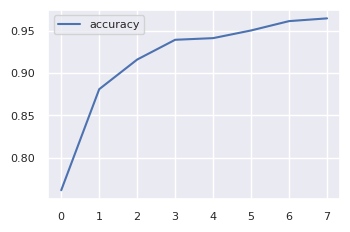

In [12]:
plt.plot(test_model.history.history["accuracy"], label="accuracy")
plt.legend()

In [13]:
best_params = study.best_params
# best_params = dict(n_conv=0, n_hidden=1, hidden_nodes=248, dropout=0.752200, filters=8, kernel_size=14, batch_size=19, epochs=75)

In [14]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 27, 14)            5684      
                                                                 
 batch_normalization_3 (Batc  (None, 27, 14)           56        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 27, 14)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 27, 14)            2954      
                                                                 
 batch_normalization_4 (Batc  (None, 27, 14)           56        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 27, 14)           

In [15]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 4ms/step
Cohen k 0.9807692307692307
Accuracy 0.9903846153846154
F1-score [0.99036609 0.99040307]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       260
           1       0.99      0.99      0.99       260

    accuracy                           0.99       520
   macro avg       0.99      0.99      0.99       520
weighted avg       0.99      0.99      0.99       520



## CNN and sex-emotion using syllables02 (mixed actors mode)

In [22]:
## Note: errors may be due to actors not being ever analysed
## Check by random partitioning instead of actor < 19
y = np.array([f"{s}-{e}" for s,e in zip(df.sex, df.emotion)])
indexes = np.arange(len(df))
np.random.shuffle(indexes)
train_indxs, test_indxs, val_indxs = np.split(indexes, (len(df)*np.cumsum([0.7, 0.2])).astype(int))

X_train, X_test, X_val = traces[train_indxs], traces[test_indxs], traces[val_indxs], 
y_train, y_test, y_val = y[train_indxs], y[test_indxs], y[val_indxs]

# #### Labels ####
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(np.unique(y_train))

(1716, 27, 27)
(490, 27, 27)
(246, 27, 27)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [19]:
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-27 13:09:04,709] A new study created in memory with name: no-name-8cbb0d3f-66e3-4d59-ba75-d28267f2764c


Running little bitch having n_conv=2, dropout=0.04405823495112209, hidden_nodes=33
Running little bitch having n_conv=0, dropout=0.08075500778035248, hidden_nodes=19
Running little bitch having n_conv=1, dropout=0.0037308198054503807, hidden_nodes=210
Running little bitch having n_conv=1, dropout=0.10505741053404989, hidden_nodes=167
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:09:19,251] Trial 1 finished with value: 0.23170731707317074 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 19, 'dropout': 0.08075500778035248, 'filters': 13, 'kernel_size': 6, 'batch_size': 61, 'epochs': 13}. Best is trial 1 with value: 0.23170731707317074.


Running little bitch having n_conv=1, dropout=0.12604435960627833, hidden_nodes=13
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:09:30,386] Trial 3 finished with value: 0.1951219512195122 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 167, 'dropout': 0.10505741053404989, 'filters': 4, 'kernel_size': 4, 'batch_size': 57, 'epochs': 13}. Best is trial 1 with value: 0.23170731707317074.


Running little bitch having n_conv=0, dropout=0.01029288057323683, hidden_nodes=127
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:09:39,696] Trial 4 finished with value: 0.17479674796747968 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 13, 'dropout': 0.12604435960627833, 'filters': 3, 'kernel_size': 7, 'batch_size': 30, 'epochs': 9}. Best is trial 1 with value: 0.23170731707317074.


Running little bitch having n_conv=3, dropout=0.09107460274950319, hidden_nodes=114
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:09:42,633] Trial 2 finished with value: 0.3089430894308943 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 210, 'dropout': 0.0037308198054503807, 'filters': 7, 'kernel_size': 3, 'batch_size': 54, 'epochs': 54}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.01182763288693316, hidden_nodes=112
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:09:58,234] Trial 5 finished with value: 0.26422764227642276 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 127, 'dropout': 0.01029288057323683, 'filters': 6, 'kernel_size': 9, 'batch_size': 34, 'epochs': 33}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.17248238251228915, hidden_nodes=156
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:10:26,908] Trial 7 finished with value: 0.26422764227642276 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 112, 'dropout': 0.01182763288693316, 'filters': 11, 'kernel_size': 12, 'batch_size': 23, 'epochs': 23}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=3, dropout=0.18460208969192402, hidden_nodes=88
8/8 [==============================] - 2s 153ms/step


[I 2023-06-27 13:10:37,059] Trial 0 finished with value: 0.25609756097560976 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 33, 'dropout': 0.04405823495112209, 'filters': 7, 'kernel_size': 11, 'batch_size': 19, 'epochs': 60}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=3, dropout=0.05521200353561273, hidden_nodes=187
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:10:44,237] Trial 8 finished with value: 0.21544715447154472 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 156, 'dropout': 0.17248238251228915, 'filters': 4, 'kernel_size': 9, 'batch_size': 22, 'epochs': 56}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=3, dropout=0.1825644238841419, hidden_nodes=208
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:11:16,280] Trial 10 finished with value: 0.13821138211382114 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 187, 'dropout': 0.05521200353561273, 'filters': 2, 'kernel_size': 6, 'batch_size': 54, 'epochs': 29}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.17660664865091188, hidden_nodes=161
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:11:24,044] Trial 6 finished with value: 0.21138211382113822 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 114, 'dropout': 0.09107460274950319, 'filters': 13, 'kernel_size': 11, 'batch_size': 28, 'epochs': 68}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.00843847214658315, hidden_nodes=252
8/8 [==============================] - 1s 17ms/step


[I 2023-06-27 13:11:25,358] Trial 11 finished with value: 0.21951219512195122 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 208, 'dropout': 0.1825644238841419, 'filters': 12, 'kernel_size': 4, 'batch_size': 59, 'epochs': 27}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.005556347657574845, hidden_nodes=250
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:12:02,746] Trial 12 finished with value: 0.2804878048780488 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 161, 'dropout': 0.17660664865091188, 'filters': 9, 'kernel_size': 6, 'batch_size': 55, 'epochs': 76}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.14277432710255397, hidden_nodes=230
8/8 [==============================] - 0s 4ms/step


[I 2023-06-27 13:12:34,961] Trial 13 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 252, 'dropout': 0.00843847214658315, 'filters': 16, 'kernel_size': 16, 'batch_size': 46, 'epochs': 90}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.1445598011892999, hidden_nodes=241
8/8 [==============================] - 0s 4ms/step


[I 2023-06-27 13:12:52,252] Trial 15 finished with value: 0.25203252032520324 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 230, 'dropout': 0.14277432710255397, 'filters': 9, 'kernel_size': 16, 'batch_size': 47, 'epochs': 90}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.19910144014536185, hidden_nodes=64
8/8 [==============================] - 0s 16ms/step


[I 2023-06-27 13:12:55,755] Trial 14 finished with value: 0.2967479674796748 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 250, 'dropout': 0.005556347657574845, 'filters': 8, 'kernel_size': 16, 'batch_size': 44, 'epochs': 87}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.034951456271387224, hidden_nodes=255
8/8 [==============================] - 1s 17ms/step


[I 2023-06-27 13:13:07,252] Trial 16 finished with value: 0.25609756097560976 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 241, 'dropout': 0.1445598011892999, 'filters': 9, 'kernel_size': 2, 'batch_size': 46, 'epochs': 78}. Best is trial 2 with value: 0.3089430894308943.
[I 2023-06-27 13:13:07,300] Trial 9 finished with value: 0.24390243902439024 and parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 88, 'dropout': 0.18460208969192402, 'filters': 9, 'kernel_size': 5, 'batch_size': 17, 'epochs': 69}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.037535642955534715, hidden_nodes=210
Running little bitch having n_conv=0, dropout=0.03745733966952317, hidden_nodes=209
8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 13:13:21,530] Trial 18 finished with value: 0.24796747967479674 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 255, 'dropout': 0.034951456271387224, 'filters': 7, 'kernel_size': 14, 'batch_size': 42, 'epochs': 45}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.0008827199817137005, hidden_nodes=209
8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 13:13:35,525] Trial 19 finished with value: 0.21544715447154472 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 210, 'dropout': 0.037535642955534715, 'filters': 6, 'kernel_size': 14, 'batch_size': 42, 'epochs': 45}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.0003897231577628252, hidden_nodes=214
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:13:35,927] Trial 20 finished with value: 0.23577235772357724 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 209, 'dropout': 0.03745733966952317, 'filters': 6, 'kernel_size': 14, 'batch_size': 39, 'epochs': 46}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.060871860413850655, hidden_nodes=187
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:13:44,017] Trial 17 finished with value: 0.3089430894308943 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 64, 'dropout': 0.19910144014536185, 'filters': 9, 'kernel_size': 3, 'batch_size': 48, 'epochs': 73}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.07202412781848677, hidden_nodes=76
8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 13:13:56,870] Trial 21 finished with value: 0.21138211382113822 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 209, 'dropout': 0.0008827199817137005, 'filters': 6, 'kernel_size': 2, 'batch_size': 64, 'epochs': 49}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.0714910688877978, hidden_nodes=60
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:14:32,233] Trial 23 finished with value: 0.25203252032520324 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 187, 'dropout': 0.060871860413850655, 'filters': 11, 'kernel_size': 2, 'batch_size': 51, 'epochs': 80}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.19582529319942274, hidden_nodes=56
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:14:32,900] Trial 22 finished with value: 0.2804878048780488 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 214, 'dropout': 0.0003897231577628252, 'filters': 11, 'kernel_size': 2, 'batch_size': 50, 'epochs': 52}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.02444986207230932, hidden_nodes=59
8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 13:14:37,443] Trial 24 finished with value: 0.25609756097560976 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 76, 'dropout': 0.07202412781848677, 'filters': 11, 'kernel_size': 2, 'batch_size': 50, 'epochs': 81}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.1974051579047835, hidden_nodes=42
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:14:43,102] Trial 25 finished with value: 0.24796747967479674 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 60, 'dropout': 0.0714910688877978, 'filters': 11, 'kernel_size': 3, 'batch_size': 51, 'epochs': 82}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.023070837423161947, hidden_nodes=52
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:15:15,827] Trial 26 finished with value: 0.23983739837398374 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 56, 'dropout': 0.19582529319942274, 'filters': 8, 'kernel_size': 4, 'batch_size': 50, 'epochs': 67}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.02429954117447604, hidden_nodes=228
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:15:17,753] Trial 28 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 42, 'dropout': 0.1974051579047835, 'filters': 8, 'kernel_size': 8, 'batch_size': 41, 'epochs': 65}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.026245864285959715, hidden_nodes=229
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:15:20,492] Trial 27 finished with value: 0.26422764227642276 and parameters: {'n_conv': 2, 'n_hidden': 0, 'hidden_nodes': 59, 'dropout': 0.02444986207230932, 'filters': 8, 'kernel_size': 4, 'batch_size': 38, 'epochs': 64}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.04814820082580195, hidden_nodes=232
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:15:25,570] Trial 29 finished with value: 0.2845528455284553 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 52, 'dropout': 0.023070837423161947, 'filters': 8, 'kernel_size': 7, 'batch_size': 37, 'epochs': 65}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.0534350478689869, hidden_nodes=230
8/8 [==============================] - 0s 5ms/step


[I 2023-06-27 13:15:57,691] Trial 30 finished with value: 0.2886178861788618 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 228, 'dropout': 0.02429954117447604, 'filters': 8, 'kernel_size': 8, 'batch_size': 36, 'epochs': 61}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.02827410312258386, hidden_nodes=230
8/8 [==============================] - 0s 5ms/step


[I 2023-06-27 13:16:06,575] Trial 32 finished with value: 0.21544715447154472 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 232, 'dropout': 0.04814820082580195, 'filters': 5, 'kernel_size': 11, 'batch_size': 35, 'epochs': 73}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.024266314863911554, hidden_nodes=186
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:16:10,412] Trial 31 finished with value: 0.1951219512195122 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 229, 'dropout': 0.026245864285959715, 'filters': 5, 'kernel_size': 12, 'batch_size': 37, 'epochs': 40}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.04697330259739246, hidden_nodes=174
8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 13:16:13,106] Trial 33 finished with value: 0.25609756097560976 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 230, 'dropout': 0.0534350478689869, 'filters': 5, 'kernel_size': 12, 'batch_size': 44, 'epochs': 58}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=0, dropout=0.017648332105562166, hidden_nodes=187
8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 13:16:30,482] Trial 35 finished with value: 0.2886178861788618 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 186, 'dropout': 0.024266314863911554, 'filters': 7, 'kernel_size': 5, 'batch_size': 43, 'epochs': 59}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.0967554396628745, hidden_nodes=147
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:16:34,695] Trial 34 finished with value: 0.2682926829268293 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 230, 'dropout': 0.02827410312258386, 'filters': 7, 'kernel_size': 11, 'batch_size': 32, 'epochs': 59}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.10474737245235495, hidden_nodes=144
8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 13:16:39,074] Trial 36 finished with value: 0.26422764227642276 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 174, 'dropout': 0.04697330259739246, 'filters': 7, 'kernel_size': 10, 'batch_size': 44, 'epochs': 59}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.09524864010014697, hidden_nodes=142
8/8 [==============================] - 0s 8ms/step


[I 2023-06-27 13:17:00,903] Trial 37 finished with value: 0.26422764227642276 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 187, 'dropout': 0.017648332105562166, 'filters': 10, 'kernel_size': 5, 'batch_size': 33, 'epochs': 85}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.09091745859983354, hidden_nodes=24
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:17:28,810] Trial 39 finished with value: 0.23577235772357724 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 144, 'dropout': 0.10474737245235495, 'filters': 10, 'kernel_size': 8, 'batch_size': 54, 'epochs': 73}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.01384712408022256, hidden_nodes=9
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:17:33,049] Trial 41 finished with value: 0.2845528455284553 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 24, 'dropout': 0.09091745859983354, 'filters': 10, 'kernel_size': 8, 'batch_size': 54, 'epochs': 53}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.013367942937532306, hidden_nodes=107
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:17:45,960] Trial 40 finished with value: 0.3089430894308943 and parameters: {'n_conv': 1, 'n_hidden': 3, 'hidden_nodes': 142, 'dropout': 0.09524864010014697, 'filters': 10, 'kernel_size': 8, 'batch_size': 28, 'epochs': 84}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.11345540149424355, hidden_nodes=108
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:18:04,125] Trial 38 finished with value: 0.24796747967479674 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 147, 'dropout': 0.0967554396628745, 'filters': 10, 'kernel_size': 8, 'batch_size': 32, 'epochs': 84}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=2, dropout=0.11156277337328946, hidden_nodes=96
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:18:11,827] Trial 43 finished with value: 0.23170731707317074 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 107, 'dropout': 0.013367942937532306, 'filters': 4, 'kernel_size': 3, 'batch_size': 58, 'epochs': 85}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=1, dropout=0.12173214611096435, hidden_nodes=130
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:18:13,258] Trial 42 finished with value: 0.3048780487804878 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 9, 'dropout': 0.01384712408022256, 'filters': 10, 'kernel_size': 3, 'batch_size': 27, 'epochs': 53}. Best is trial 2 with value: 0.3089430894308943.


Running little bitch having n_conv=3, dropout=0.007163682924033234, hidden_nodes=87
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:18:50,973] Trial 44 finished with value: 0.3170731707317073 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 108, 'dropout': 0.11345540149424355, 'filters': 13, 'kernel_size': 7, 'batch_size': 27, 'epochs': 86}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=3, dropout=0.11383226479702924, hidden_nodes=90
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:19:09,638] Trial 47 finished with value: 0.21544715447154472 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 87, 'dropout': 0.007163682924033234, 'filters': 13, 'kernel_size': 3, 'batch_size': 27, 'epochs': 39}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=2, dropout=0.11331927007221505, hidden_nodes=11
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:19:17,196] Trial 46 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 130, 'dropout': 0.12173214611096435, 'filters': 15, 'kernel_size': 10, 'batch_size': 27, 'epochs': 72}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=2, dropout=0.11184435494085221, hidden_nodes=23
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:19:41,851] Trial 45 finished with value: 0.25609756097560976 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 96, 'dropout': 0.11156277337328946, 'filters': 8, 'kernel_size': 7, 'batch_size': 28, 'epochs': 72}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=2, dropout=0.1558242740032822, hidden_nodes=9
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:20:05,282] Trial 51 finished with value: 0.2032520325203252 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 9, 'dropout': 0.1558242740032822, 'filters': 15, 'kernel_size': 6, 'batch_size': 24, 'epochs': 7}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=2, dropout=0.08235009699520474, hidden_nodes=117
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:20:07,317] Trial 48 finished with value: 0.2886178861788618 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 90, 'dropout': 0.11383226479702924, 'filters': 14, 'kernel_size': 3, 'batch_size': 27, 'epochs': 74}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=2, dropout=0.084914702589423, hidden_nodes=30
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:20:16,215] Trial 49 finished with value: 0.2926829268292683 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 11, 'dropout': 0.11331927007221505, 'filters': 14, 'kernel_size': 6, 'batch_size': 23, 'epochs': 72}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.08620288912104881, hidden_nodes=71
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:20:28,068] Trial 50 finished with value: 0.25203252032520324 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 23, 'dropout': 0.11184435494085221, 'filters': 14, 'kernel_size': 7, 'batch_size': 23, 'epochs': 75}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.1355053592966231, hidden_nodes=116
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:20:44,640] Trial 53 finished with value: 0.24390243902439024 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 30, 'dropout': 0.084914702589423, 'filters': 12, 'kernel_size': 5, 'batch_size': 16, 'epochs': 20}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.16242437796833517, hidden_nodes=69
8/8 [==============================] - 0s 5ms/step


[I 2023-06-27 13:21:39,294] Trial 55 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 116, 'dropout': 0.1355053592966231, 'filters': 12, 'kernel_size': 4, 'batch_size': 20, 'epochs': 88}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.16815953616218582, hidden_nodes=69
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:21:44,828] Trial 52 finished with value: 0.2764227642276423 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 117, 'dropout': 0.08235009699520474, 'filters': 13, 'kernel_size': 4, 'batch_size': 19, 'epochs': 76}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.16479079319743417, hidden_nodes=77
8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 13:21:49,032] Trial 54 finished with value: 0.2967479674796748 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 71, 'dropout': 0.08620288912104881, 'filters': 12, 'kernel_size': 4, 'batch_size': 20, 'epochs': 88}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=0, dropout=0.1639498105258879, hidden_nodes=246
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:22:20,094] Trial 56 finished with value: 0.2682926829268293 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 69, 'dropout': 0.16242437796833517, 'filters': 12, 'kernel_size': 15, 'batch_size': 18, 'epochs': 88}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=0, dropout=0.0394136099621881, hidden_nodes=40
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:22:25,998] Trial 57 finished with value: 0.25203252032520324 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 69, 'dropout': 0.16815953616218582, 'filters': 9, 'kernel_size': 15, 'batch_size': 48, 'epochs': 79}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=0, dropout=0.005238382050656146, hidden_nodes=44
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:22:32,969] Trial 58 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 77, 'dropout': 0.16479079319743417, 'filters': 9, 'kernel_size': 9, 'batch_size': 56, 'epochs': 88}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=0, dropout=0.0024313925531555796, hidden_nodes=199
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:22:51,413] Trial 59 finished with value: 0.2926829268292683 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 246, 'dropout': 0.1639498105258879, 'filters': 9, 'kernel_size': 9, 'batch_size': 30, 'epochs': 80}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=3, dropout=0.033882152866325635, hidden_nodes=37
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:22:53,508] Trial 60 finished with value: 0.2967479674796748 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 40, 'dropout': 0.0394136099621881, 'filters': 10, 'kernel_size': 9, 'batch_size': 47, 'epochs': 78}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.0050345307306310216, hidden_nodes=196
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:23:02,971] Trial 62 finished with value: 0.2682926829268293 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 199, 'dropout': 0.0024313925531555796, 'filters': 10, 'kernel_size': 3, 'batch_size': 62, 'epochs': 83}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.013657639839990028, hidden_nodes=96
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:23:13,138] Trial 61 finished with value: 0.25203252032520324 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 44, 'dropout': 0.005238382050656146, 'filters': 10, 'kernel_size': 3, 'batch_size': 30, 'epochs': 83}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.013767447439241708, hidden_nodes=105
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:23:33,305] Trial 63 finished with value: 0.23577235772357724 and parameters: {'n_conv': 3, 'n_hidden': 0, 'hidden_nodes': 37, 'dropout': 0.033882152866325635, 'filters': 10, 'kernel_size': 3, 'batch_size': 62, 'epochs': 52}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.013458585161553405, hidden_nodes=103
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:24:03,567] Trial 66 finished with value: 0.3008130081300813 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 105, 'dropout': 0.013767447439241708, 'filters': 11, 'kernel_size': 5, 'batch_size': 45, 'epochs': 90}. Best is trial 44 with value: 0.3170731707317073.


8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:24:03,895] Trial 64 finished with value: 0.23577235772357724 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 196, 'dropout': 0.0050345307306310216, 'filters': 10, 'kernel_size': 3, 'batch_size': 21, 'epochs': 83}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.01513007598665661, hidden_nodes=142
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:24:11,392] Trial 65 finished with value: 0.3089430894308943 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 96, 'dropout': 0.013657639839990028, 'filters': 11, 'kernel_size': 5, 'batch_size': 25, 'epochs': 90}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.015320303615066241, hidden_nodes=140
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:24:35,763] Trial 69 finished with value: 0.3089430894308943 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 142, 'dropout': 0.01513007598665661, 'filters': 11, 'kernel_size': 6, 'batch_size': 52, 'epochs': 39}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.017772244158097687, hidden_nodes=122
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:24:37,160] Trial 67 finished with value: 0.3008130081300813 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 103, 'dropout': 0.013458585161553405, 'filters': 11, 'kernel_size': 2, 'batch_size': 25, 'epochs': 90}. Best is trial 44 with value: 0.3170731707317073.


Running little bitch having n_conv=1, dropout=0.06293242295449836, hidden_nodes=141
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:25:09,940] Trial 71 finished with value: 0.3252032520325203 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 122, 'dropout': 0.017772244158097687, 'filters': 11, 'kernel_size': 6, 'batch_size': 25, 'epochs': 37}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.1816955306068176, hidden_nodes=124
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:25:12,026] Trial 68 finished with value: 0.2764227642276423 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 141, 'dropout': 0.01631426907018088, 'filters': 11, 'kernel_size': 5, 'batch_size': 25, 'epochs': 90}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.01779419632739866, hidden_nodes=125
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:25:14,086] Trial 72 finished with value: 0.3089430894308943 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 141, 'dropout': 0.06293242295449836, 'filters': 13, 'kernel_size': 7, 'batch_size': 25, 'epochs': 40}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.07026264225403336, hidden_nodes=122
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:25:29,240] Trial 73 finished with value: 0.2804878048780488 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 124, 'dropout': 0.1816955306068176, 'filters': 13, 'kernel_size': 6, 'batch_size': 52, 'epochs': 32}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.07359947774817328, hidden_nodes=157
8/8 [==============================] - 0s 8ms/step


[I 2023-06-27 13:25:33,127] Trial 74 finished with value: 0.24390243902439024 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 125, 'dropout': 0.01779419632739866, 'filters': 12, 'kernel_size': 7, 'batch_size': 53, 'epochs': 37}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.032634572931498476, hidden_nodes=157
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:25:41,777] Trial 75 finished with value: 0.2764227642276423 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 122, 'dropout': 0.07026264225403336, 'filters': 13, 'kernel_size': 7, 'batch_size': 25, 'epochs': 35}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.03199029586259027, hidden_nodes=136
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:25:44,008] Trial 70 finished with value: 0.25203252032520324 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 140, 'dropout': 0.015320303615066241, 'filters': 11, 'kernel_size': 5, 'batch_size': 26, 'epochs': 69}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.04218751108799247, hidden_nodes=157
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:25:58,884] Trial 76 finished with value: 0.24796747967479674 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 157, 'dropout': 0.07359947774817328, 'filters': 12, 'kernel_size': 7, 'batch_size': 29, 'epochs': 40}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.02995481158286486, hidden_nodes=174
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:26:07,980] Trial 77 finished with value: 0.2926829268292683 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 157, 'dropout': 0.032634572931498476, 'filters': 13, 'kernel_size': 6, 'batch_size': 25, 'epochs': 42}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.04179670895705183, hidden_nodes=135
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:26:19,110] Trial 79 finished with value: 0.3008130081300813 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 157, 'dropout': 0.04218751108799247, 'filters': 12, 'kernel_size': 6, 'batch_size': 29, 'epochs': 42}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.05473348694388912, hidden_nodes=167
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:26:21,883] Trial 78 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 136, 'dropout': 0.03199029586259027, 'filters': 11, 'kernel_size': 6, 'batch_size': 22, 'epochs': 44}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.05998751514757018, hidden_nodes=174
8/8 [==============================] - 0s 8ms/step


[I 2023-06-27 13:26:30,150] Trial 80 finished with value: 0.25609756097560976 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 174, 'dropout': 0.02995481158286486, 'filters': 13, 'kernel_size': 6, 'batch_size': 22, 'epochs': 25}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.010142991217564196, hidden_nodes=165
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:26:41,400] Trial 83 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 174, 'dropout': 0.05998751514757018, 'filters': 9, 'kernel_size': 8, 'batch_size': 59, 'epochs': 28}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.021266257935305195, hidden_nodes=133
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:26:48,497] Trial 81 finished with value: 0.23577235772357724 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 135, 'dropout': 0.04179670895705183, 'filters': 9, 'kernel_size': 6, 'batch_size': 22, 'epochs': 47}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.009983393763367075, hidden_nodes=99
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:26:50,301] Trial 82 finished with value: 0.2601626016260163 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 167, 'dropout': 0.05473348694388912, 'filters': 15, 'kernel_size': 6, 'batch_size': 49, 'epochs': 30}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.021367373591588537, hidden_nodes=150
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:27:13,961] Trial 85 finished with value: 0.15447154471544716 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 133, 'dropout': 0.021266257935305195, 'filters': 3, 'kernel_size': 7, 'batch_size': 33, 'epochs': 49}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.0011506939588578672, hidden_nodes=96
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:27:21,221] Trial 84 finished with value: 0.1910569105691057 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 165, 'dropout': 0.010142991217564196, 'filters': 3, 'kernel_size': 8, 'batch_size': 31, 'epochs': 49}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.00868775657973363, hidden_nodes=148
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:27:22,379] Trial 86 finished with value: 0.2886178861788618 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 99, 'dropout': 0.009983393763367075, 'filters': 11, 'kernel_size': 2, 'batch_size': 49, 'epochs': 49}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.027923108024968786, hidden_nodes=111
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:27:46,435] Trial 87 finished with value: 0.24390243902439024 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 150, 'dropout': 0.021367373591588537, 'filters': 14, 'kernel_size': 4, 'batch_size': 31, 'epochs': 55}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.0261993598743445, hidden_nodes=111
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:28:06,023] Trial 91 finished with value: 0.25203252032520324 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 111, 'dropout': 0.0261993598743445, 'filters': 10, 'kernel_size': 5, 'batch_size': 55, 'epochs': 35}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.00029260519291768186, hidden_nodes=94
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:28:06,894] Trial 88 finished with value: 0.22357723577235772 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 96, 'dropout': 0.0011506939588578672, 'filters': 14, 'kernel_size': 4, 'batch_size': 56, 'epochs': 62}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.008924038360972929, hidden_nodes=111
1/8 [==>...........................] - ETA: 5s

[I 2023-06-27 13:28:19,138] Trial 89 finished with value: 0.23577235772357724 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 148, 'dropout': 0.00868775657973363, 'filters': 14, 'kernel_size': 4, 'batch_size': 28, 'epochs': 54}. Best is trial 71 with value: 0.3252032520325203.


8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:28:19,247] Trial 90 finished with value: 0.2764227642276423 and parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 111, 'dropout': 0.027923108024968786, 'filters': 14, 'kernel_size': 4, 'batch_size': 57, 'epochs': 55}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.018595473105473666, hidden_nodes=107
Running little bitch having n_conv=1, dropout=0.020166276317102536, hidden_nodes=83
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:28:23,975] Trial 93 finished with value: 0.2682926829268293 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 111, 'dropout': 0.008924038360972929, 'filters': 16, 'kernel_size': 7, 'batch_size': 28, 'epochs': 17}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.01871285084594656, hidden_nodes=86
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:28:33,694] Trial 92 finished with value: 0.25609756097560976 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 94, 'dropout': 0.00029260519291768186, 'filters': 6, 'kernel_size': 7, 'batch_size': 28, 'epochs': 37}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.01999243285828163, hidden_nodes=86
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:28:52,672] Trial 94 finished with value: 0.3048780487804878 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 107, 'dropout': 0.018595473105473666, 'filters': 11, 'kernel_size': 5, 'batch_size': 46, 'epochs': 38}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.017619814343663012, hidden_nodes=79
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:29:09,208] Trial 95 finished with value: 0.23983739837398374 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 83, 'dropout': 0.020166276317102536, 'filters': 11, 'kernel_size': 5, 'batch_size': 46, 'epochs': 86}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.04683169831368965, hidden_nodes=49
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:29:15,894] Trial 96 finished with value: 0.2601626016260163 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 86, 'dropout': 0.01871285084594656, 'filters': 11, 'kernel_size': 5, 'batch_size': 45, 'epochs': 86}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.03651206749765995, hidden_nodes=131
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:29:24,529] Trial 97 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 86, 'dropout': 0.01999243285828163, 'filters': 11, 'kernel_size': 5, 'batch_size': 52, 'epochs': 85}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.09910821126055944, hidden_nodes=129
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:29:30,315] Trial 99 finished with value: 0.2804878048780488 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 49, 'dropout': 0.04683169831368965, 'filters': 12, 'kernel_size': 2, 'batch_size': 52, 'epochs': 43}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.09706971313786407, hidden_nodes=121
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:29:36,442] Trial 98 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 79, 'dropout': 0.017619814343663012, 'filters': 11, 'kernel_size': 5, 'batch_size': 51, 'epochs': 86}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.035650455952750765, hidden_nodes=130
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:29:45,309] Trial 100 finished with value: 0.2845528455284553 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 131, 'dropout': 0.03651206749765995, 'filters': 12, 'kernel_size': 8, 'batch_size': 40, 'epochs': 43}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.014353587203243354, hidden_nodes=105
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:29:54,113] Trial 101 finished with value: 0.3089430894308943 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 129, 'dropout': 0.09910821126055944, 'filters': 12, 'kernel_size': 8, 'batch_size': 41, 'epochs': 31}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.09782368462497229, hidden_nodes=122
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:30:04,189] Trial 102 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 121, 'dropout': 0.09706971313786407, 'filters': 8, 'kernel_size': 8, 'batch_size': 41, 'epochs': 39}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.09035924019934963, hidden_nodes=117
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:30:10,614] Trial 104 finished with value: 0.24390243902439024 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 105, 'dropout': 0.014353587203243354, 'filters': 10, 'kernel_size': 7, 'batch_size': 47, 'epochs': 33}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.10107797866624646, hidden_nodes=217
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:30:23,914] Trial 105 finished with value: 0.3130081300813008 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 122, 'dropout': 0.09782368462497229, 'filters': 10, 'kernel_size': 8, 'batch_size': 24, 'epochs': 32}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.09046942800864805, hidden_nodes=119
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:30:29,491] Trial 103 finished with value: 0.2926829268292683 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 130, 'dropout': 0.035650455952750765, 'filters': 7, 'kernel_size': 8, 'batch_size': 24, 'epochs': 32}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.10215410589117978, hidden_nodes=17
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:30:32,631] Trial 106 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 117, 'dropout': 0.09035924019934963, 'filters': 10, 'kernel_size': 7, 'batch_size': 24, 'epochs': 31}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.10516563976639054, hidden_nodes=151
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:30:33,700] Trial 107 finished with value: 0.2601626016260163 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 217, 'dropout': 0.10107797866624646, 'filters': 12, 'kernel_size': 9, 'batch_size': 43, 'epochs': 31}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.1047968818327991, hidden_nodes=15
8/8 [==============================] - 0s 4ms/step


[I 2023-06-27 13:30:58,868] Trial 111 finished with value: 0.24390243902439024 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 15, 'dropout': 0.1047968818327991, 'filters': 9, 'kernel_size': 9, 'batch_size': 26, 'epochs': 27}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.1202159997854817, hidden_nodes=64
8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 13:31:00,058] Trial 109 finished with value: 0.3048780487804878 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 17, 'dropout': 0.10215410589117978, 'filters': 10, 'kernel_size': 10, 'batch_size': 24, 'epochs': 26}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.11835413936975792, hidden_nodes=152
8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:31:03,932] Trial 110 finished with value: 0.2601626016260163 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 151, 'dropout': 0.10516563976639054, 'filters': 9, 'kernel_size': 8, 'batch_size': 26, 'epochs': 27}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.07718330084424069, hidden_nodes=128
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:31:12,305] Trial 108 finished with value: 0.2886178861788618 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 119, 'dropout': 0.09046942800864805, 'filters': 10, 'kernel_size': 10, 'batch_size': 24, 'epochs': 31}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.0945288981950264, hidden_nodes=137
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:31:25,918] Trial 112 finished with value: 0.3008130081300813 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 64, 'dropout': 0.1202159997854817, 'filters': 13, 'kernel_size': 10, 'batch_size': 26, 'epochs': 34}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.00541139290364687, hidden_nodes=140
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:31:28,572] Trial 114 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 128, 'dropout': 0.07718330084424069, 'filters': 11, 'kernel_size': 3, 'batch_size': 38, 'epochs': 36}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.19970557655080437, hidden_nodes=102
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:31:29,557] Trial 113 finished with value: 0.2886178861788618 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 152, 'dropout': 0.11835413936975792, 'filters': 12, 'kernel_size': 8, 'batch_size': 26, 'epochs': 34}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.09538234310141563, hidden_nodes=140
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:31:38,971] Trial 115 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 137, 'dropout': 0.0945288981950264, 'filters': 11, 'kernel_size': 3, 'batch_size': 39, 'epochs': 35}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.1259074040898506, hidden_nodes=144
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:32:05,671] Trial 116 finished with value: 0.2682926829268293 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 140, 'dropout': 0.00541139290364687, 'filters': 12, 'kernel_size': 3, 'batch_size': 21, 'epochs': 36}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.1350856071971811, hidden_nodes=101
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:32:11,762] Trial 117 finished with value: 0.2764227642276423 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 102, 'dropout': 0.19970557655080437, 'filters': 12, 'kernel_size': 7, 'batch_size': 21, 'epochs': 38}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.13049782156766684, hidden_nodes=125
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:32:13,111] Trial 118 finished with value: 0.2682926829268293 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 140, 'dropout': 0.09538234310141563, 'filters': 10, 'kernel_size': 6, 'batch_size': 20, 'epochs': 38}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.024869357017958, hidden_nodes=115
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:32:31,054] Trial 119 finished with value: 0.3170731707317073 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 144, 'dropout': 0.1259074040898506, 'filters': 12, 'kernel_size': 6, 'batch_size': 21, 'epochs': 39}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.1260912134668667, hidden_nodes=146
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:32:36,146] Trial 122 finished with value: 0.2967479674796748 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 115, 'dropout': 0.024869357017958, 'filters': 13, 'kernel_size': 7, 'batch_size': 29, 'epochs': 22}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.12859044788504162, hidden_nodes=125
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:32:38,842] Trial 120 finished with value: 0.24796747967479674 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 101, 'dropout': 0.1350856071971811, 'filters': 10, 'kernel_size': 6, 'batch_size': 29, 'epochs': 38}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.10884928410755006, hidden_nodes=125
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:32:52,360] Trial 121 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 125, 'dropout': 0.13049782156766684, 'filters': 11, 'kernel_size': 6, 'batch_size': 23, 'epochs': 41}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.10990181252354403, hidden_nodes=145
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:33:12,055] Trial 123 finished with value: 0.23577235772357724 and parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 146, 'dropout': 0.1260912134668667, 'filters': 13, 'kernel_size': 6, 'batch_size': 17, 'epochs': 22}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.011896384871813047, hidden_nodes=107
8/8 [==============================] - 0s 5ms/step


[I 2023-06-27 13:33:29,599] Trial 124 finished with value: 0.32113821138211385 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 125, 'dropout': 0.12859044788504162, 'filters': 13, 'kernel_size': 6, 'batch_size': 23, 'epochs': 41}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.11745334232407999, hidden_nodes=134
8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 13:33:33,842] Trial 125 finished with value: 0.24796747967479674 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 125, 'dropout': 0.10884928410755006, 'filters': 11, 'kernel_size': 6, 'batch_size': 18, 'epochs': 41}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.11059421368720117, hidden_nodes=31
8/8 [==============================] - 1s 7ms/step


[I 2023-06-27 13:33:39,562] Trial 127 finished with value: 0.2804878048780488 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 107, 'dropout': 0.011896384871813047, 'filters': 11, 'kernel_size': 9, 'batch_size': 27, 'epochs': 40}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06671434792144817, hidden_nodes=143
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:33:45,132] Trial 126 finished with value: 0.3008130081300813 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 145, 'dropout': 0.10990181252354403, 'filters': 13, 'kernel_size': 7, 'batch_size': 35, 'epochs': 47}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.14688919311146734, hidden_nodes=31
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:34:09,645] Trial 129 finished with value: 0.2926829268292683 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 31, 'dropout': 0.11059421368720117, 'filters': 13, 'kernel_size': 7, 'batch_size': 27, 'epochs': 46}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.11644032184531483, hidden_nodes=163
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:34:13,188] Trial 128 finished with value: 0.25203252032520324 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 134, 'dropout': 0.11745334232407999, 'filters': 13, 'kernel_size': 7, 'batch_size': 19, 'epochs': 45}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=2, dropout=0.08620984331542383, hidden_nodes=120
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:34:19,582] Trial 130 finished with value: 0.3170731707317073 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 143, 'dropout': 0.06671434792144817, 'filters': 13, 'kernel_size': 7, 'batch_size': 23, 'epochs': 46}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06876956658836235, hidden_nodes=162
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:34:28,697] Trial 131 finished with value: 0.3130081300813008 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 31, 'dropout': 0.14688919311146734, 'filters': 12, 'kernel_size': 7, 'batch_size': 23, 'epochs': 46}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.1534789261430042, hidden_nodes=129
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:35:11,540] Trial 134 finished with value: 0.3130081300813008 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 162, 'dropout': 0.06876956658836235, 'filters': 12, 'kernel_size': 8, 'batch_size': 23, 'epochs': 51}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06742392231362766, hidden_nodes=179
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:35:13,192] Trial 135 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 129, 'dropout': 0.1534789261430042, 'filters': 12, 'kernel_size': 8, 'batch_size': 23, 'epochs': 51}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06204228365937598, hidden_nodes=163
8/8 [==============================] - 1s 15ms/step


[I 2023-06-27 13:35:21,431] Trial 133 finished with value: 0.2886178861788618 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 120, 'dropout': 0.08620984331542383, 'filters': 12, 'kernel_size': 8, 'batch_size': 23, 'epochs': 57}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06360712985462884, hidden_nodes=239
8/8 [==============================] - 1s 13ms/step


[I 2023-06-27 13:35:37,594] Trial 132 finished with value: 0.22357723577235772 and parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 163, 'dropout': 0.11644032184531483, 'filters': 12, 'kernel_size': 8, 'batch_size': 25, 'epochs': 81}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06830070076635181, hidden_nodes=182
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:36:06,648] Trial 137 finished with value: 0.3008130081300813 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 163, 'dropout': 0.06204228365937598, 'filters': 12, 'kernel_size': 6, 'batch_size': 22, 'epochs': 44}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.12372965863173332, hidden_nodes=153
8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 13:36:12,856] Trial 136 finished with value: 0.3130081300813008 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 179, 'dropout': 0.06742392231362766, 'filters': 12, 'kernel_size': 7, 'batch_size': 23, 'epochs': 51}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.12393673855482074, hidden_nodes=183
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:36:13,984] Trial 138 finished with value: 0.2967479674796748 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 239, 'dropout': 0.06360712985462884, 'filters': 13, 'kernel_size': 6, 'batch_size': 22, 'epochs': 45}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.07936040866712726, hidden_nodes=195
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:36:31,040] Trial 139 finished with value: 0.2967479674796748 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 182, 'dropout': 0.06830070076635181, 'filters': 13, 'kernel_size': 7, 'batch_size': 22, 'epochs': 44}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.0780213724041551, hidden_nodes=170
8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 13:37:17,163] Trial 141 finished with value: 0.2845528455284553 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 183, 'dropout': 0.12393673855482074, 'filters': 13, 'kernel_size': 7, 'batch_size': 21, 'epochs': 50}. Best is trial 71 with value: 0.3252032520325203.


8/8 [==============================] - 1s 13ms/step


[I 2023-06-27 13:37:17,589] Trial 142 finished with value: 0.27235772357723576 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 195, 'dropout': 0.07936040866712726, 'filters': 14, 'kernel_size': 7, 'batch_size': 20, 'epochs': 48}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.07603201508943173, hidden_nodes=196
Running little bitch having n_conv=1, dropout=0.19270327590741526, hidden_nodes=169
8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 13:37:36,322] Trial 140 finished with value: 0.2926829268292683 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 153, 'dropout': 0.12372965863173332, 'filters': 13, 'kernel_size': 7, 'batch_size': 21, 'epochs': 77}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06563795208175982, hidden_nodes=169
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:37:39,543] Trial 143 finished with value: 0.26422764227642276 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 170, 'dropout': 0.0780213724041551, 'filters': 14, 'kernel_size': 7, 'batch_size': 19, 'epochs': 50}. Best is trial 71 with value: 0.3252032520325203.


Running little bitch having n_conv=1, dropout=0.06680738001710863, hidden_nodes=141
8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 13:38:12,556] Trial 144 finished with value: 0.34146341463414637 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 196, 'dropout': 0.07603201508943173, 'filters': 14, 'kernel_size': 7, 'batch_size': 24, 'epochs': 48}. Best is trial 144 with value: 0.34146341463414637.


Running little bitch having n_conv=1, dropout=0.19429768204624265, hidden_nodes=217
8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 13:38:13,821] Trial 145 finished with value: 0.2926829268292683 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 169, 'dropout': 0.19270327590741526, 'filters': 12, 'kernel_size': 7, 'batch_size': 24, 'epochs': 51}. Best is trial 144 with value: 0.34146341463414637.


Running little bitch having n_conv=1, dropout=0.07480588956955865, hidden_nodes=219
8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 13:38:24,167] Trial 147 finished with value: 0.25609756097560976 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 141, 'dropout': 0.06680738001710863, 'filters': 12, 'kernel_size': 6, 'batch_size': 24, 'epochs': 41}. Best is trial 144 with value: 0.34146341463414637.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 13:38:35,972] Trial 146 finished with value: 0.3130081300813008 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 169, 'dropout': 0.06563795208175982, 'filters': 12, 'kernel_size': 6, 'batch_size': 24, 'epochs': 67}. Best is trial 144 with value: 0.34146341463414637.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-27 13:38:49,766] Trial 148 finished with value: 0.3252032520325203 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 217, 'dropout': 0.19429768204624265, 'filters': 12, 'kernel_size': 9, 'batch_size': 23, 'epochs': 46}. Best is trial 144 with value: 0.34146341463414637.


8/8 [==============================] - 0s 3ms/step


[I 2023-06-27 13:38:50,252] Trial 149 finished with value: 0.22764227642276422 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 219, 'dropout': 0.07480588956955865, 'filters': 6, 'kernel_size': 6, 'batch_size': 23, 'epochs': 53}. Best is trial 144 with value: 0.34146341463414637.


In [25]:
best_params = study.best_params
print(best_params)
cnn_emosex = build_model((27,27), 16, **best_params)
cnn_emosex.summary()
cnn_emosex.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

{'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 196, 'dropout': 0.07603201508943173, 'filters': 14, 'kernel_size': 7, 'batch_size': 24, 'epochs': 48}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 27, 14)            2660      
                                                                 
 batch_normalization_17 (Bat  (None, 27, 14)           56        
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 27, 14)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 27, 14)            1386      
                                                                 
 batch_normalization_18 (Bat  (None, 27, 14)           56        
 chNormalization)                      

In [27]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score, confusion_matrix

y_pred = np.argmax(cnn_emosex.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

16/16 [==============================] - 0s 3ms/step
Cohen k 0.23773530769885998
Accuracy 0.29183673469387755
F1-score [0.43589744 0.43478261 0.26315789 0.22580645 0.43076923 0.17647059
 0.11111111 0.2745098  0.46428571 0.42857143 0.17391304 0.10526316
 0.26666667 0.         0.19565217 0.06896552]
              precision    recall  f1-score   support

           0       0.40      0.47      0.44        36
           1       0.34      0.61      0.43        33
           2       0.28      0.25      0.26        20
           3       0.28      0.19      0.23        37
           4       0.44      0.42      0.43        33
           5       0.25      0.14      0.18        22
           6       0.11      0.11      0.11        35
           7       0.26      0.29      0.27        24
           8       0.68      0.35      0.46        37
           9       0.31      0.68      0.43        44
          10       0.50      0.11      0.17        19
          11       0.14      0.08      0.11        3

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


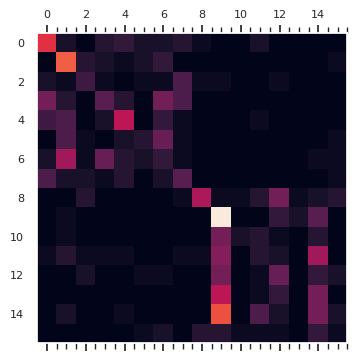

In [28]:
plt.matshow(confusion_matrix(y_test, y_pred))
plt.grid(ls="")

## CNN and emotion using complete STFT

In [61]:
file_path = os.path.join(TS_PREPROC_FOLDER, f"full_stft.npy")
full_stft = np.load(file_path, allow_pickle=True)


# Sets tests to be over actor 19 (excluded)
X_test = full_stft[df.actor_number > 19]
y_test = df["emotion"][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  full_stft[df.actor_number <= 19], 
                                                    df["emotion"][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 54, 54), (387, 54, 54), (520, 54, 54), (1545,), (387,), (520,))

In [62]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(np.unique(y_train))

[0 1 2 3 4 5 6 7]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


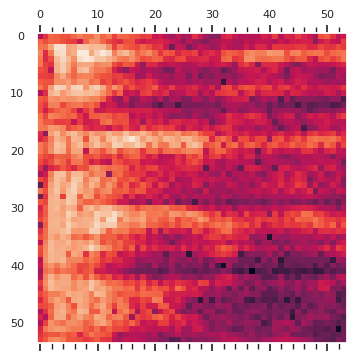

In [63]:
plt.matshow(X_train[0]);
plt.grid(ls="")

In [64]:
# objective function to be minimized
def objective_fun_bigger_model(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 2, 5)
    n_hidden = trial.suggest_int('n_hidden', 2, 5)
    hidden_nodes = trial.suggest_int('hidden_nodes', 256, 512)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 16, 32)
    kernel_size = trial.suggest_int('kernel_size', 2, 32)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 40, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


In [65]:
# Test to check the accuracy of a "belly" network
test_model = build_model((54,54), 8, 
                         n_conv=5, n_hidden=5, hidden_nodes=512, filters=32, kernel_size=16)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=90)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 54, 32)            27680     
                                                                 
 batch_normalization_47 (Bat  (None, 54, 32)           128       
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (None, 54, 32)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 54, 32)            16416     
                                                                 
 batch_normalization_48 (Bat  (None, 54, 32)           128       
 chNormalization)                                                
                                                                 
 activation_48 (Activation)  (None, 54, 32)          

49/49 [==============================] - 4s 79ms/step - loss: 1.5464 - accuracy: 0.3036
Epoch 35/90
49/49 [==============================] - 4s 89ms/step - loss: 1.5517 - accuracy: 0.3107
Epoch 36/90
49/49 [==============================] - 4s 91ms/step - loss: 1.4806 - accuracy: 0.3120
Epoch 37/90
49/49 [==============================] - 4s 75ms/step - loss: 1.4963 - accuracy: 0.3243
Epoch 38/90
49/49 [==============================] - 5s 105ms/step - loss: 1.4121 - accuracy: 0.3417
Epoch 39/90
49/49 [==============================] - 7s 134ms/step - loss: 1.4296 - accuracy: 0.3502
Epoch 40/90
49/49 [==============================] - 5s 104ms/step - loss: 1.4054 - accuracy: 0.3689
Epoch 41/90
49/49 [==============================] - 4s 84ms/step - loss: 1.3197 - accuracy: 0.3987
Epoch 42/90
49/49 [==============================] - 4s 80ms/step - loss: 1.3718 - accuracy: 0.3916
Epoch 43/90
49/49 [==============================] - 4s 92ms/step - loss: 1.3389 - accuracy: 0.3890
Epoch 44/

In [50]:
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun_bigger_model(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-27 11:04:59,081] A new study created in memory with name: no-name-0c3a3fb6-6b9e-4ff6-a080-0978d56ff11f


Running little bitch having n_conv=5, dropout=0.13954109746273538, hidden_nodes=402
Running little bitch having n_conv=5, dropout=0.06798737901863594, hidden_nodes=299
Running little bitch having n_conv=5, dropout=0.16766378790162637, hidden_nodes=387
Running little bitch having n_conv=5, dropout=0.013343607846261298, hidden_nodes=378


[W 2023-06-27 11:04:59,631] Trial 2 failed with parameters: {'n_conv': 5, 'n_hidden': 5, 'hidden_nodes': 387, 'dropout': 0.16766378790162637, 'filters': 26, 'kernel_size': 21, 'batch_size': 48, 'epochs': 62} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 14, 26] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/918379503.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun_bigger_model(trial,
  File "/tmp/ipykernel_8299/2492497974.py", line 15, in objective_fun_bigger_model
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937

Running little bitch having n_conv=3, dropout=0.11605496511470684, hidden_nodes=393


[W 2023-06-27 11:04:59,942] Trial 3 failed with parameters: {'n_conv': 5, 'n_hidden': 2, 'hidden_nodes': 378, 'dropout': 0.013343607846261298, 'filters': 24, 'kernel_size': 16, 'batch_size': 36, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_2. Consider increasing the input size. Received input shape [None, 9, 24] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/918379503.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun_bigger_model(trial,
  File "/tmp/ipykernel_8299/2492497974.py", line 15, in objective_fun_bigger_model
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937

Running little bitch having n_conv=2, dropout=0.14436943741463998, hidden_nodes=506


[W 2023-06-27 11:05:00,499] Trial 1 failed with parameters: {'n_conv': 5, 'n_hidden': 3, 'hidden_nodes': 299, 'dropout': 0.06798737901863594, 'filters': 16, 'kernel_size': 10, 'batch_size': 51, 'epochs': 82} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_4" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_4/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_4/Conv1D/ExpandDims, extra_conv_4/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,16], [1,10,16,16].\n\nCall arguments received by layer "extra_conv_4" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 16), dtype=float32)').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_value

Running little bitch having n_conv=4, dropout=0.07400767135214002, hidden_nodes=391


[W 2023-06-27 11:05:01,073] Trial 6 failed with parameters: {'n_conv': 4, 'n_hidden': 2, 'hidden_nodes': 391, 'dropout': 0.07400767135214002, 'filters': 24, 'kernel_size': 23, 'batch_size': 24, 'epochs': 40} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 10, 24] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_8299/918379503.py", line 2, in <lambda>
    trial_function = lambda trial: objective_fun_bigger_model(trial,
  File "/tmp/ipykernel_8299/2492497974.py", line 15, in objective_fun_bigger_model
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
  File "/tmp/ipykernel_8299/1937

Running little bitch having n_conv=2, dropout=0.008194824605227425, hidden_nodes=469


[W 2023-06-27 11:05:01,452] Trial 7 failed with parameters: {'n_conv': 2, 'n_hidden': 5, 'hidden_nodes': 469, 'dropout': 0.008194824605227425, 'filters': 22, 'kernel_size': 28, 'batch_size': 33, 'epochs': 58} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_0" (type Conv1D).\n\nNegative dimension size caused by subtracting 28 from 27 for \'{{node extra_conv_0/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_0/Conv1D/ExpandDims, extra_conv_0/Conv1D/ExpandDims_1)\' with input shapes: [?,1,27,22], [1,28,22,22].\n\nCall arguments received by layer "extra_conv_0" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 27, 22), dtype=float32)').
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_v

Running little bitch having n_conv=5, dropout=0.07641577248552522, hidden_nodes=359



KeyboardInterrupt



In [ ]:
best_params = study.best_params
print(best_params)
cnn = build_model((54,54), 2, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

In [66]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 1s 14ms/step
Cohen k -0.007089745806674763
Accuracy 0.13846153846153847
F1-score [0.18421053 0.07092199 0.17073171 0.19178082 0.15966387 0.03571429
 0.07476636 0.04444444]
              precision    recall  f1-score   support

           0       0.19      0.17      0.18        80
           1       0.08      0.06      0.07        80
           2       0.17      0.17      0.17        40
           3       0.15      0.26      0.19        80
           4       0.12      0.24      0.16        80
           5       0.06      0.03      0.04        40
           6       0.15      0.05      0.07        80
           7       0.20      0.03      0.04        40

    accuracy                           0.14       520
   macro avg       0.14      0.13      0.12       520
weighted avg       0.14      0.14      0.12       520



## LSTM and emotion using full STFT

In [8]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

def build_LSTM(input_shape, n_categories,
                lstm_nodes=64,  
                n_dense=0, dense_nodes=32,
                dropout=0.01, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()
    model.add(LSTM(lstm_nodes, 
                   input_shape=input_shape,
                   dropout=0.05,
                   recurrent_dropout=0.05,
                   name="LSTM_base"))

#     for i in range(n_lstm):
#         model.add(LSTM(lstm_nodes, name=f"extra_LSTM_{i}"))
#         model.add(Dropout(dropout))

    for i in range(n_dense):
        model.add(Dense(dense_nodes, activation='relu', name=f"extra_Dense_{i}"))
        model.add(Dropout(dropout))
    model.add(Dense(n_categories, activation='softmax')) 
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

2023-06-27 13:01:50.534144: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 13:01:50.936449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 13:01:50.938430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 13:01:53.115890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [148]:
file_path = os.path.join(TS_PREPROC_FOLDER, f"full_stft.npy")
full_stft = np.load(file_path, allow_pickle=True)
y = df.statement.to_numpy()

## Note: errors may be due to actors not being ever analysed
## Check by random partitioning instead of actor < 19

indexes = np.arange(len(df))
np.random.shuffle(indexes)
train_indxs, test_indxs, val_indxs = np.split(indexes, (len(df)*np.cumsum([0.7, 0.2])).astype(int))

X_train, X_test, X_val = full_stft[train_indxs], full_stft[test_indxs], full_stft[val_indxs], 
y_train, y_test, y_val = y[train_indxs], y[test_indxs], y[val_indxs]

# #### Labels ####
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(np.unique(y_train))

(1716, 54, 54)
(490, 54, 54)
(246, 54, 54)
[0 1]


In [149]:
# Test to check the accuracy of a "belly" network
test_model = build_LSTM((54,54), len(np.unique(y_train)), 
                        lstm_nodes=64, 
                        n_dense=2, dense_nodes=64)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_base (LSTM)            (None, 64)                30464     
                                                                 
 extra_Dense_0 (Dense)       (None, 64)                4160      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 extra_Dense_1 (Dense)       (None, 64)                4160      
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                                                                 
 dense_75 (Dense)            (None, 2)                 130       
                                                                 
Total params: 38,914
Trainable params: 38,914
Non-tra

In [150]:
# objective function to be minimized
def objective_fun_LSTM_model(trial, X, y, validation_X, validation_y):
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        lstm_nodes=trial.suggest_int('lstm_nodes', 32, 128),
                        n_dense=trial.suggest_int('n_hidden', 1, 4),
                        dense_nodes=trial.suggest_int('dense_nodes', 64, 512),
                        dropout=trial.suggest_float('dropout', 0, 0.10),
                       )

    cnn.fit(X, y, 
            batch_size=trial.suggest_int('batch_size', 16, 64), 
            epochs=trial.suggest_int('epochs', 8, 60), 
            verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error

In [151]:
study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun_LSTM_model(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=50, n_jobs=-1, catch=ValueError)

[I 2023-06-27 12:31:52,746] A new study created in memory with name: no-name-210bb442-bd96-4153-91c0-e31e8006844d


1/8 [==>...........................] - ETA: 4s

[I 2023-06-27 12:32:11,460] Trial 3 finished with value: 0.5121951219512195 and parameters: {'lstm_nodes': 63, 'n_hidden': 3, 'dense_nodes': 480, 'dropout': 0.06908333040604829, 'batch_size': 30, 'epochs': 10}. Best is trial 3 with value: 0.5121951219512195.


8/8 [==============================] - 1s 17ms/step


[I 2023-06-27 12:32:11,727] Trial 1 finished with value: 0.491869918699187 and parameters: {'lstm_nodes': 68, 'n_hidden': 3, 'dense_nodes': 259, 'dropout': 0.04273256425763559, 'batch_size': 53, 'epochs': 13}. Best is trial 3 with value: 0.5121951219512195.
[I 2023-06-27 12:32:11,738] Trial 0 finished with value: 0.508130081300813 and parameters: {'lstm_nodes': 105, 'n_hidden': 3, 'dense_nodes': 455, 'dropout': 0.07454130941610985, 'batch_size': 34, 'epochs': 16}. Best is trial 3 with value: 0.5121951219512195.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-27 12:32:37,233] Trial 2 finished with value: 0.483739837398374 and parameters: {'lstm_nodes': 127, 'n_hidden': 1, 'dense_nodes': 342, 'dropout': 0.002640255086194965, 'batch_size': 41, 'epochs': 59}. Best is trial 3 with value: 0.5121951219512195.


8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 12:32:41,425] Trial 4 finished with value: 0.5284552845528455 and parameters: {'lstm_nodes': 124, 'n_hidden': 2, 'dense_nodes': 176, 'dropout': 0.030589459291459953, 'batch_size': 35, 'epochs': 30}. Best is trial 4 with value: 0.5284552845528455.


8/8 [==============================] - 1s 13ms/step


[I 2023-06-27 12:32:50,326] Trial 5 finished with value: 0.5365853658536586 and parameters: {'lstm_nodes': 47, 'n_hidden': 3, 'dense_nodes': 209, 'dropout': 0.08272729591768192, 'batch_size': 16, 'epochs': 22}. Best is trial 5 with value: 0.5365853658536586.


8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 12:33:01,183] Trial 6 finished with value: 0.44308943089430897 and parameters: {'lstm_nodes': 114, 'n_hidden': 4, 'dense_nodes': 70, 'dropout': 0.07394611073375758, 'batch_size': 31, 'epochs': 43}. Best is trial 5 with value: 0.5365853658536586.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 12:33:16,927] Trial 9 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 81, 'n_hidden': 2, 'dense_nodes': 139, 'dropout': 0.033114211809176855, 'batch_size': 45, 'epochs': 34}. Best is trial 5 with value: 0.5365853658536586.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-27 12:33:20,344] Trial 10 finished with value: 0.540650406504065 and parameters: {'lstm_nodes': 49, 'n_hidden': 2, 'dense_nodes': 336, 'dropout': 0.005898624319305568, 'batch_size': 62, 'epochs': 12}. Best is trial 10 with value: 0.540650406504065.


8/8 [==============================] - 1s 6ms/step


[I 2023-06-27 12:33:21,450] Trial 7 finished with value: 0.5121951219512195 and parameters: {'lstm_nodes': 91, 'n_hidden': 4, 'dense_nodes': 391, 'dropout': 0.022419472088982064, 'batch_size': 20, 'epochs': 35}. Best is trial 10 with value: 0.540650406504065.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-27 12:33:24,509] Trial 8 finished with value: 0.516260162601626 and parameters: {'lstm_nodes': 64, 'n_hidden': 3, 'dense_nodes': 273, 'dropout': 0.027208757996532607, 'batch_size': 19, 'epochs': 33}. Best is trial 10 with value: 0.540650406504065.


8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 12:33:31,177] Trial 11 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 114, 'n_hidden': 1, 'dense_nodes': 353, 'dropout': 0.09342980471906352, 'batch_size': 39, 'epochs': 14}. Best is trial 10 with value: 0.540650406504065.


8/8 [==============================] - 0s 5ms/step


[I 2023-06-27 12:33:50,974] Trial 13 finished with value: 0.4796747967479675 and parameters: {'lstm_nodes': 34, 'n_hidden': 1, 'dense_nodes': 317, 'dropout': 0.0007868369192437635, 'batch_size': 64, 'epochs': 50}. Best is trial 10 with value: 0.540650406504065.


5/8 [=================>............] - ETA: 0s

[I 2023-06-27 12:33:53,341] Trial 14 finished with value: 0.5284552845528455 and parameters: {'lstm_nodes': 40, 'n_hidden': 1, 'dense_nodes': 213, 'dropout': 0.0986391651143019, 'batch_size': 63, 'epochs': 21}. Best is trial 10 with value: 0.540650406504065.


8/8 [==============================] - 0s 23ms/step


[I 2023-06-27 12:33:53,588] Trial 12 finished with value: 0.5447154471544715 and parameters: {'lstm_nodes': 55, 'n_hidden': 4, 'dense_nodes': 466, 'dropout': 0.007452162751794944, 'batch_size': 29, 'epochs': 36}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-27 12:33:58,151] Trial 15 finished with value: 0.5365853658536586 and parameters: {'lstm_nodes': 33, 'n_hidden': 2, 'dense_nodes': 208, 'dropout': 0.05515194270438531, 'batch_size': 64, 'epochs': 23}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 12:34:12,173] Trial 17 finished with value: 0.5 and parameters: {'lstm_nodes': 51, 'n_hidden': 2, 'dense_nodes': 202, 'dropout': 0.04913110063090043, 'batch_size': 53, 'epochs': 23}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 11ms/step


[I 2023-06-27 12:34:16,348] Trial 16 finished with value: 0.5121951219512195 and parameters: {'lstm_nodes': 36, 'n_hidden': 2, 'dense_nodes': 212, 'dropout': 0.055653382445778055, 'batch_size': 64, 'epochs': 23}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 12:34:20,440] Trial 18 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 57, 'n_hidden': 2, 'dense_nodes': 425, 'dropout': 0.013697078056150218, 'batch_size': 52, 'epochs': 43}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 1s 17ms/step


[I 2023-06-27 12:34:46,988] Trial 19 finished with value: 0.483739837398374 and parameters: {'lstm_nodes': 50, 'n_hidden': 4, 'dense_nodes': 414, 'dropout': 0.013402250442715365, 'batch_size': 25, 'epochs': 44}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 1s 13ms/step


[I 2023-06-27 12:34:51,551] Trial 20 finished with value: 0.5365853658536586 and parameters: {'lstm_nodes': 53, 'n_hidden': 4, 'dense_nodes': 439, 'dropout': 0.015519944267490938, 'batch_size': 24, 'epochs': 41}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 12:35:08,001] Trial 21 finished with value: 0.5 and parameters: {'lstm_nodes': 54, 'n_hidden': 4, 'dense_nodes': 412, 'dropout': 0.0142185543925686, 'batch_size': 25, 'epochs': 44}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 12:35:09,683] Trial 22 finished with value: 0.516260162601626 and parameters: {'lstm_nodes': 81, 'n_hidden': 4, 'dense_nodes': 496, 'dropout': 0.01088514792625428, 'batch_size': 25, 'epochs': 41}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 12:35:14,662] Trial 23 finished with value: 0.4878048780487805 and parameters: {'lstm_nodes': 76, 'n_hidden': 4, 'dense_nodes': 503, 'dropout': 0.011922714997122616, 'batch_size': 26, 'epochs': 28}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 12:35:17,388] Trial 24 finished with value: 0.483739837398374 and parameters: {'lstm_nodes': 76, 'n_hidden': 3, 'dense_nodes': 372, 'dropout': 0.00017660575415875263, 'batch_size': 26, 'epochs': 29}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 12:35:26,367] Trial 26 finished with value: 0.491869918699187 and parameters: {'lstm_nodes': 46, 'n_hidden': 3, 'dense_nodes': 129, 'dropout': 0.00022591988048220601, 'batch_size': 16, 'epochs': 8}. Best is trial 12 with value: 0.5447154471544715.


8/8 [==============================] - 1s 14ms/step


[I 2023-06-27 12:35:30,538] Trial 27 finished with value: 0.5528455284552846 and parameters: {'lstm_nodes': 42, 'n_hidden': 3, 'dense_nodes': 299, 'dropout': 0.0005993034992159687, 'batch_size': 16, 'epochs': 8}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 12:35:43,328] Trial 25 finished with value: 0.5487804878048781 and parameters: {'lstm_nodes': 44, 'n_hidden': 3, 'dense_nodes': 487, 'dropout': 0.0001558755121882395, 'batch_size': 18, 'epochs': 27}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 12:35:43,910] Trial 29 finished with value: 0.5365853658536586 and parameters: {'lstm_nodes': 44, 'n_hidden': 3, 'dense_nodes': 306, 'dropout': 0.037864988154178755, 'batch_size': 46, 'epochs': 18}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 1s 19ms/step


[I 2023-06-27 12:35:45,873] Trial 28 finished with value: 0.532520325203252 and parameters: {'lstm_nodes': 43, 'n_hidden': 3, 'dense_nodes': 303, 'dropout': 0.0370760824821377, 'batch_size': 16, 'epochs': 18}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 0s 12ms/step


[I 2023-06-27 12:35:47,179] Trial 30 finished with value: 0.5365853658536586 and parameters: {'lstm_nodes': 42, 'n_hidden': 2, 'dense_nodes': 286, 'dropout': 0.02322877342954126, 'batch_size': 58, 'epochs': 18}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 12:36:12,667] Trial 31 finished with value: 0.508130081300813 and parameters: {'lstm_nodes': 40, 'n_hidden': 3, 'dense_nodes': 463, 'dropout': 0.019292588358713628, 'batch_size': 20, 'epochs': 17}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 12:36:14,963] Trial 34 finished with value: 0.508130081300813 and parameters: {'lstm_nodes': 60, 'n_hidden': 3, 'dense_nodes': 460, 'dropout': 0.005875523946946247, 'batch_size': 21, 'epochs': 12}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 12:36:28,905] Trial 36 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 70, 'n_hidden': 2, 'dense_nodes': 251, 'dropout': 0.006595791929380632, 'batch_size': 30, 'epochs': 8}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 1s 8ms/step


[I 2023-06-27 12:36:30,069] Trial 35 finished with value: 0.532520325203252 and parameters: {'lstm_nodes': 59, 'n_hidden': 3, 'dense_nodes': 467, 'dropout': 0.006808761786421422, 'batch_size': 30, 'epochs': 11}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 1s 15ms/step


[I 2023-06-27 12:36:39,435] Trial 32 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 59, 'n_hidden': 3, 'dense_nodes': 458, 'dropout': 0.025057930850806025, 'batch_size': 20, 'epochs': 50}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 12:36:46,623] Trial 33 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 94, 'n_hidden': 4, 'dense_nodes': 474, 'dropout': 0.023047348655466295, 'batch_size': 20, 'epochs': 55}. Best is trial 27 with value: 0.5528455284552846.


8/8 [==============================] - 0s 10ms/step


[I 2023-06-27 12:36:58,411] Trial 39 finished with value: 0.5609756097560976 and parameters: {'lstm_nodes': 97, 'n_hidden': 4, 'dense_nodes': 335, 'dropout': 0.00671840915666535, 'batch_size': 34, 'epochs': 15}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 0s 8ms/step


[I 2023-06-27 12:37:02,233] Trial 37 finished with value: 0.508130081300813 and parameters: {'lstm_nodes': 94, 'n_hidden': 3, 'dense_nodes': 344, 'dropout': 0.005537823332052922, 'batch_size': 37, 'epochs': 38}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 9ms/step


[I 2023-06-27 12:37:04,484] Trial 38 finished with value: 0.5 and parameters: {'lstm_nodes': 68, 'n_hidden': 3, 'dense_nodes': 346, 'dropout': 0.007563605020168078, 'batch_size': 34, 'epochs': 37}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 18ms/step


[I 2023-06-27 12:37:19,403] Trial 40 finished with value: 0.5121951219512195 and parameters: {'lstm_nodes': 68, 'n_hidden': 2, 'dense_nodes': 331, 'dropout': 0.006611380320210911, 'batch_size': 34, 'epochs': 37}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 13ms/step


[I 2023-06-27 12:37:21,350] Trial 42 finished with value: 0.5284552845528455 and parameters: {'lstm_nodes': 102, 'n_hidden': 4, 'dense_nodes': 368, 'dropout': 0.018088801155232447, 'batch_size': 34, 'epochs': 15}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 12ms/step


[I 2023-06-27 12:37:27,238] Trial 41 finished with value: 0.524390243902439 and parameters: {'lstm_nodes': 90, 'n_hidden': 4, 'dense_nodes': 381, 'dropout': 0.00835587905183817, 'batch_size': 36, 'epochs': 27}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 10ms/step


[I 2023-06-27 12:37:31,290] Trial 43 finished with value: 0.5284552845528455 and parameters: {'lstm_nodes': 102, 'n_hidden': 4, 'dense_nodes': 252, 'dropout': 0.019368290861800672, 'batch_size': 32, 'epochs': 26}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 19ms/step


[I 2023-06-27 12:37:35,902] Trial 44 finished with value: 0.5040650406504065 and parameters: {'lstm_nodes': 104, 'n_hidden': 4, 'dense_nodes': 376, 'dropout': 0.018470050643822275, 'batch_size': 43, 'epochs': 13}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 0s 6ms/step


[I 2023-06-27 12:37:45,756] Trial 46 finished with value: 0.5 and parameters: {'lstm_nodes': 47, 'n_hidden': 4, 'dense_nodes': 259, 'dropout': 0.002644781592540963, 'batch_size': 43, 'epochs': 10}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 1s 11ms/step


[I 2023-06-27 12:37:50,190] Trial 45 finished with value: 0.532520325203252 and parameters: {'lstm_nodes': 48, 'n_hidden': 4, 'dense_nodes': 388, 'dropout': 0.01005537726074128, 'batch_size': 43, 'epochs': 27}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 0s 7ms/step


[I 2023-06-27 12:37:59,455] Trial 47 finished with value: 0.532520325203252 and parameters: {'lstm_nodes': 48, 'n_hidden': 4, 'dense_nodes': 401, 'dropout': 0.0032043303604833546, 'batch_size': 42, 'epochs': 32}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 12:38:00,509] Trial 48 finished with value: 0.5203252032520326 and parameters: {'lstm_nodes': 118, 'n_hidden': 3, 'dense_nodes': 402, 'dropout': 0.003098812216461202, 'batch_size': 49, 'epochs': 32}. Best is trial 39 with value: 0.5609756097560976.


8/8 [==============================] - 0s 9ms/step


[I 2023-06-27 12:38:04,827] Trial 49 finished with value: 0.5487804878048781 and parameters: {'lstm_nodes': 112, 'n_hidden': 1, 'dense_nodes': 509, 'dropout': 0.0022563179219774075, 'batch_size': 49, 'epochs': 32}. Best is trial 39 with value: 0.5609756097560976.


In [152]:
best_params = study.best_params
print(best_params)
lstm = build_model((54,54), 8, **best_params)
lstm.summary()
lstm.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

{'lstm_nodes': 97, 'n_hidden': 4, 'dense_nodes': 335, 'dropout': 0.00671840915666535, 'batch_size': 34, 'epochs': 15}
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 54, 8)             2168      
                                                                 
 batch_normalization_56 (Bat  (None, 54, 8)            32        
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, 54, 8)             0         
                                                                 
 global_average_pooling1d_19  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_76 (Dense)            (None, 32)                288       
 

In [ ]:
y_pred = np.argmax(lstm.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(y_test, y_pred))
plt.grid(ls="")

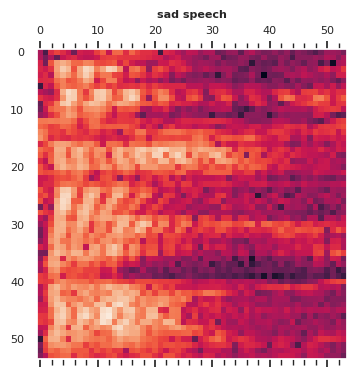

In [143]:
indx = 800
plt.matshow(X_train[indx])
plt.title(f"{df.emotion[indx]} {df.vocal_channel[indx]}")
plt.grid(ls="")